# Loading data by using pandas dataframe

In [1]:
%matplotlib notebook
import os
folder = os.getcwd()+'/'
folderData = 'datasets/'
fileDev = 'development.csv'
fileEval = 'evaluation.csv'

import numpy as np

import matplotlib.pyplot as plt
from nltk.corpus import stopwords as sw
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import normalize

import pandas as pd

reviews_dev_df = pd.read_csv(folder + folderData + fileDev)
reviews_eval_df = pd.read_csv(folder + folderData + fileEval)

# DATA EXPLORATION 

# Handling missing values

In [2]:
reviews_dev_df.dropna()
print(reviews_dev_df.shape)

(28754, 2)


# Outliers Detection

In [ ]:
from langdetect import detect
docs=[]
indices=[]
for ind,doc in enumerate(reviews_dev_df['text']):
    if detect(doc) != 'it':
        docs.append(doc)
        indices.append(ind)

for i,d in zip(indices,docs):
    print('Review:\n',d,'\nIndex:',i,'\tClass:',reviews_dev_df.loc[i,'class'],'\n\n\n')

reviews_dev_df.drop(index=indices)
print(reviews_dev_df.shape)

# Stastics about length of reviews

<IPython.core.display.Javascript object>


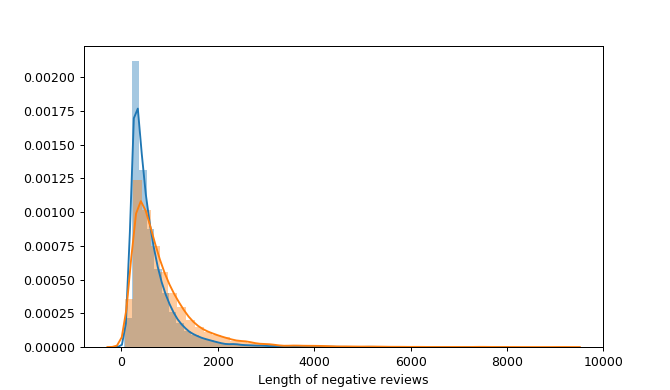

Percentage of pos reviews : 67.92794046045768
Percentage of pos reviews : 32.07205953954232 

Length of pos reviews (mean) : 624
Length of neg reviews (mean) : 864 

Length of pos reviews (median) : 465
Length of neg reviews (median) : 644 

Length of pos reviews (95% quantile) : 1549
Length of neg reviews (95% quantile) : 2231 

Length of pos reviews (5% quantile) : 219
Length of neg reviews (5% quantile) : 238


In [4]:
import seaborn as sns
%matplotlib notebook

reviews_dev_df['length']=reviews_dev_df['text'].apply( lambda x : len(x))
reviews_eval_df['length']=reviews_eval_df['text'].apply( lambda x : len(x))

sns.distplot(reviews_dev_df[reviews_dev_df['class']=='pos']['length'],axlabel='Length of positive reviews')
sns.distplot(reviews_dev_df[reviews_dev_df['class']=='neg']['length'],axlabel='Length of negative reviews')

print('Percentage of pos reviews :',reviews_dev_df[reviews_dev_df['class']=='pos'].shape[0]/reviews_dev_df.shape[0]*100)
print('Percentage of pos reviews :',reviews_dev_df[reviews_dev_df['class']=='neg'].shape[0]/reviews_dev_df.shape[0]*100,'\n')
print('Length of pos reviews (mean) :',int(reviews_dev_df[reviews_dev_df['class']=='pos']['length'].mean()))
print('Length of neg reviews (mean) :',int(reviews_dev_df[reviews_dev_df['class']=='neg']['length'].mean()),'\n')
print('Minimum length of pos reviews:',int(reviews_dev_df[reviews_dev_df['class']=='pos']['length'].min()))
print('Minimum length of neg reviews:',int(reviews_dev_df[reviews_dev_df['class']=='neg']['length'].min()),'\n')
print('Length of pos reviews (median) :',int(reviews_dev_df[reviews_dev_df['class']=='pos']['length'].quantile(0.5)))
print('Length of neg reviews (median) :',int(reviews_dev_df[reviews_dev_df['class']=='neg']['length'].quantile(0.5)),'\n')
print('Length of pos reviews (95% quantile) :',int(reviews_dev_df[reviews_dev_df['class']=='pos']['length'].quantile(0.95)))
print('Length of neg reviews (95% quantile) :',int(reviews_dev_df[reviews_dev_df['class']=='neg']['length'].quantile(0.95)),'\n')
print('Length of pos reviews (5% quantile) :',int(reviews_dev_df[reviews_dev_df['class']=='pos']['length'].quantile(0.05)))
print('Length of neg reviews (5% quantile) :',int(reviews_dev_df[reviews_dev_df['class']=='neg']['length'].quantile(0.05)))




# PREPROCESSING

# Tokenization

In [3]:
import string
import re
from nltk.corpus import stopwords
italian_stopwords = stopwords.words('italian')
italian_stopwords.remove('non')
def listToString(lista):
    s = ''
    for word in lista:
        s += word + ' '
    
    return s

def remove_punctuation(text):
    for p in (string.punctuation + "'" +"\n"):
        text = text.replace(p,' ')
        
    
    return text

def extract_tokens(text,italian_stopwords):
    clean_text=[]
    other_stopwords = italian_stopwords +\
                    ['stare','trovare','volere','fare','stare','dire','potere'] +\
                    ['stato','stati','stata','dato','fatto','chiesto','visto','trovato','detto'] +\
                    ['colazione','camera','camere','hotel', 'albergo','stanza','struttura','reception'] +\
                    ['per','su','tra','fra','quando','quindi','così'] +\
                    ['venezia','milano','napoli'] +\
                    ['gennaio','febbraio','marzo','aprile','maggio','giugno','luglio','agosto','settembre','ottobre','novembre','dicembre'] +\
                    ['lunedì','martedì','mercoledì','giovedì','venerdì','sabato','domenica']
    for w in text.split(' '):
        if ( len(w)<=2 )  or (bool(re.search(r'\d', w)) == True) :
            continue
        w=w.lower()
        if w not in other_stopwords:
            clean_text.append(w)
    return listToString(clean_text)

def tokenize(text,stopwords):
    text=remove_punctuation(text)
    tokens = extract_tokens(text,stopwords)
    return tokens
    
reviews_dev_df['tokens'] = reviews_dev_df['text'].apply(lambda doc : tokenize(doc,italian_stopwords))
reviews_eval_df['tokens'] = reviews_eval_df['text'].apply(lambda doc : tokenize(doc,italian_stopwords))
reviews_dev_df['num_of_words']=reviews_dev_df['tokens'].apply( lambda x : len(x.split(' ')))
reviews_eval_df['num_of_words']=reviews_eval_df['tokens'].apply( lambda x : len(x.split(' ')))



# Word cloud generation

In [ ]:
from wordcloud import WordCloud

def get_positive_reviews(reviews_dev_df):
    positives = reviews_dev_df[reviews_dev_df['class']=='pos']['tokens']
    return listToString(positives)

def get_negative_reviews(reviews_dev_df):
    negatives = reviews_dev_df[reviews_dev_df['class']=='neg']['tokens']
    return listToString(negatives)
    

wordcloud_pos=WordCloud(background_color='white',width=1200,height=1000).generate_from_text(get_positive_reviews(reviews_dev_df))
wordcloud_neg=WordCloud(background_color='white',width=1200,height=1000).generate_from_text(get_negative_reviews(reviews_dev_df))

#PLOTS 
%matplotlib notebook
print("Positives :\n",wordcloud_pos.words_)
print("Negatives :\n",wordcloud_neg.words_)


plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.figure()
plt.imshow(wordcloud_neg, interpolation="bilinear")
#sns.distplot(pos_lengths)
#sns.distplot(neg_lengths)

# Stemming

In [4]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('italian')

def stem(tokens):
    stemmed_tokens=[]
    for x in tokens.split(' '):
        stemmed_tokens.append(stemmer.stem(x))
    
    return listToString(stemmed_tokens)
        
    
reviews_dev_df['stemmed_tokens'] = reviews_dev_df['tokens'].apply(lambda token : stem(token) )
reviews_eval_df['stemmed_tokens'] = reviews_eval_df['tokens'].apply(lambda token : stem(token))
reviews_dev_df['stemmed_tokens']

0        non lussuos mai soggiorn esperit compless prim...
1        qui nott prim sinistr crocier personal molt ge...
2        ben posizion visit torin circ ferm autobus aer...
3        arriv cordial disponibil staff qualit ala nuov...
4        soggiorn due nott fin crocier personal molt co...
                               ...                        
28749    vecc caratterist dev compless present ben posi...
28750    esser stell spartan non recent ristruttur stan...
28751    mamm età compres giorn incred res ancor specia...
28752    sent accolt coccol fin iniz gentilissim recepc...
28753    soggiorn fantast posizion fantast connession i...
Name: stemmed_tokens, Length: 28754, dtype: object

# TF-IDF

In [7]:
reviews_vectorizer = TfidfVectorizer(min_df = 5,ngram_range=(1,2),norm='l2')
reviews_vectorizer.fit(reviews_dev_df['stemmed_tokens'],list(reviews_dev_df['class']))
tfidf_reviews_dev = reviews_vectorizer.transform(reviews_dev_df['stemmed_tokens'])
tfidf_reviews_eval =reviews_vectorizer.transform(reviews_eval_df['stemmed_tokens'])
print(tfidf_reviews_dev.shape)



(28754, 55783)


# Tomek-links

In [8]:
from imblearn.under_sampling import TomekLinks,AllKNN

tm = TomekLinks(sampling_strategy='all')
tfidf_reviews_dev_us,labels_us = tm.fit_resample(tfidf_reviews_dev,reviews_dev_df['class'])




# KNN 

In [18]:
knn=AllKNN(sampling_strategy='all')
tfidf_reviews_dev_knn,labels_knn = knn.fit_resample(normalize(tfidf_reviews_dev),reviews_dev_df['class'])
for i,r in enumerate(reviews_dev_df['text']):
    if i not in knn.sample_indices_:
        print(r,'\nIndex:',i,'\tClass:',reviews_dev_df.loc[i,'class'],'\n\n',)

Abbiamo soggiornato in questo hotel prima e guardare avanti, al nostro ritorno. L'hotel è incantevole, e la camera era ottima. Un paio di "critiche: la vasca idromassaggio non funzionava nella nostra camera, e abbiamo sentito il feedback da un altro ospite. In aggiunta, un paio di gli asciugamani erano molto usurati, e io non ti aspetteresti che da questo tipo di hotel.
Detto questo, però, ci tornerei senza alcuna ambivalenza. Le camere sono confortevoli e pulite e la colazione è ottima. 
Index: 11 	Class: pos 


Un soggiorno a Lido soltanto per due notti mi ha lasciato che vogliono più. Il Panorama Hotel offre splendide vedute di Venezia, che dista solo un breve tragitto in autobus di acqua lontano. Il personale era estremamente cordiale e le camere pulite. Consiglio vivamente l'escursione in barca gratuita a Murano. Non solo è stato il giro in barca molto bella, un breve gratuitamente la visualizzazione del talentuoso vetro veneziano accessori lavorando, valeva il viaggio. 
Index: 12

Non riesco a immaginare come questo atteggiamento servirà l'Hotel Napoleon come essi cercano four-star designazione. 
Index: 480 	Class: neg 


Hotel non villaggio sicuramente non da 4 stelle, ragazza con treccia reception molto fredda e poco cortese, hotel caro rispetto a ciò che offre, abbiamo trascorso una settimana in pensione completa, stanze pulite , wi fi nella nostra è quella di amici non funzionante, comunicato al direttore ma .... Niente ... , ristorante carino , camerieri gentilissimi , ma nn da 4 stelle , pietanze semplici e misere, colazione scarsissima, caffè al mattino tutto era tranne che caffè, aranciata rossa  una volta era acqua, un altra volta gasata, ecc , tessera clab ...,inutile visto che nn offre nulla oltre animazione con grossa percentuale per bambini, GROSSA PECCA MANCANZA Di SPIAGGIA PRIVATA, ATTENZIONE ti dicono spiaggia convenzionata , si è vero ma bisogna prenotarla 4/5 mesi prima e informarti dei posti prima di prenotare hotel altrimenti come noi nn abbi

Posizione ottimale e cibo gradevole ma la proposta? Una vera indecenza  che loro definiscono dependance un pochino datata. 5 posti letto di cui 1 in una pseudo veranda senza tende oscuranti, gli altri 4 in  camere comunicanti separate da una struttura di legno impolverato e 1  camera matrimoniale sena finestra non parliamo degli animali provenienti dall'esterno. Aggiungerei oltre al danno la beffa ci peomettono di cambiare posizione e poi iiiiii abbiamo noi dovuto cambiare struttura.VERGOGNA un 4 stelle a nessuno dei suoi clienti dovrebbe proporre una soluzione simile a maggior ragione se si tratta di una famiglia credetemi una "specie di baracca annessa all'hotel 
Index: 913 	Class: neg 


Sono stato  in questo hotel ai primi di agosto di quest'anno con mia moglie, mio figlio e amici, per l'ormai consueta vacanza di gruppo: sono infatti diversi anni che scegliamo questo hotel per il nostro soggiorno estivo in montagna.
Al di la del fatto che l'albergo si deve davvero rinnovare in tutt

Index: 1478 	Class: pos 


Lati positivi prima. La prima colazione. La colazione era fantastica ogni giorno, fresco e delizioso, con caffè corretto. Il personale qui sono ignare per voi. Non buona mattina, nemmeno il riconoscimento che avete camminato. Essi non sono giustamente scortese semplicemente non vedere voi. E' possibile che non c'è personale sufficiente per consentire loro di dare è che l'attenzione, ed è un vero peccato, come ogni volta abbiamo dovuto parlare con il personale che è stato sempre gentile e disponibile. C'è sempre un'attesa di essere serviti al bar da un cameriere molto trafficato che aveva anche modo troppe responsabilità di avere tempo per interagire con gli ospiti. Le camere erano ben tenute e pulite ma la nostra camera di fianco al 3° piano dell'edificio principale era lontana dalle camere che abbiamo visto quando abbiamo prenotato questa vacanza. Era un 2 * la camera, piccola e molto semplice, con il bagno era il più piccolo che abbia mai visto. Siamo rimas

Index: 1992 	Class: neg 


Premettendo che abbiamo scelto questo hotel per il prezzo inferiore rispetto ad altri e proprio l'abbiamo preso last minute , non tenendo conto di tripadvisor e recensioni varie, (abbiamo prenotato alle dieci e alle due eravamo lì, dello stesso giorno.), quindi vorrei giustificare la stanza  orribile dataci, ho detto bene, per questo motivo. L'accoglienza è stata discreta, niente attese estenuanti , abbiamo dovuto lasciare i tre euro a testa di tassa di soggiorno immediatamente, non capisco perché subito, in altri hotel l'abbiamo saldata alla fine, ci hanno dato una stanza al primo piano con un arredamento del tutto vecchio, polveroso, sporco e mal curato, solito stile veneziano. La stanza era su due piani, sotto bagno, condizionatore 15/18 (apparentemente guasto, la donna di servizio ci aveva praticamente detto che era mal funzionante e di attendere un pò prima dell'accensione), Televisione schermo piatto semplice semplice, bagno, scrittoio, armadio distrutt

Index: 2521 	Class: neg 


Viaggio molto sia per lavoro che per piacere ... Non mi era mai successo di presentarmi all'hotel (con prenotazione di un settimana in anticipo ) ed esser rimbalzata senza preavviso !!!!! Nè telefonicamete nè via email ! Non commento la ragazza della reception ! Sn davvero arrabbiata ! Per comodità ho scelto un altro hotel della catena ma a 3 stelle via conca del naviglio ... Non potete capire che stanza oscena mi hanno dato ! È minuscola saran 10 metri quadrati e veramente datata ! Oltre al disagio e la perdita di tempo ... Davvero la cordialità e il saper dialogare con i clienti manca davvero ! Piuttosto pago 100 euro in più ma non prenoterô mai più una stanza di questa catena alberghiera ! 
Index: 2525 	Class: neg 


Romantico e rilassante. L'atmosfera che si respira e' di assoluta i intimità. Ottima la scelta dei 7 ristoranti diversificati per menù . Ottimo servizio navetta per il mare. 
La scelta delle luci eccessivamente soft può essere non proprio cond

Abbiamo soggiornato qui per festeggiare il nostro 15° anniversario di matrimonio, questa era la nostra prima volta a Venezia, e siamo rimasti molto soddisfatti di questo hotel. E' molto pulito e silenzioso, e il personale è molto attento e cordiale. E' molto caratteristico e l'arredamento è semplice eleganza. Abbiamo apprezzato il fatto che eravamo così vicino a piazza San Marco e anche non troppo dal ponte di Rialto. Abbiamo avuto alcuna difficoltà a trovare l'albergo la nostra prima notte, e la colazione era proprio e deliziosa! 
Index: 3162 	Class: pos 


Ho scelto questa struttura per la vicinanza alla zona fieristica in occasione del comicon, mi sono trovata bene, la camera era ampia e pulita, non si sentivano rumori, il personale gentilissimo, la colazione semplice ma accontentava tutti i gusti. 
Index: 3167 	Class: pos 


Poche parole per descrivere lo squallore del loro aperitivo. 
Camerieri incapaci e improvvisati. Buffet da far piangere con crocchette scomposte deformi e pien

Index: 3857 	Class: pos 


Questo hotel è stato scelto per la sua posizione. Siamo stati proprio in centro, vicino alle rovine, ristoranti e uffici di informazioni turistiche. C'era un solo membro maschile del personale che era molto accogliente, gentile e disponibile. Il posto era molto pulito con asciugamani e biancheria da letto incantevoli, ma l'intero hotel ha bisogno di un rinnovo completo. Ci sono stati dei problemi con cablaggio vecchia e per tutta la durata della nostra permanenza i frigoriferi nelle nostre camere non hanno funzionato. La colazione a buffet era molto scarsa con poca scelta ! Tuttavia abbiamo apprezzato le gite fuori che era molto piacevole. 
Index: 3858 	Class: neg 


Dall'esterno sembra una struttura spettacolare ma poi dentro una grande delusione.
La camera e la vasca da bagno sporche, poco curate, le ragnatele vicino ai muri. Rappresentavi alla reception le lamentele è il personale faceva finta di prendere nota.
L'indomani era sempre la stessa cosa infatti 

Index: 4534 	Class: pos 


La colazione era eccellente, le camere sono spaziose, con un sacco di spazio a disposizione. Estate potrebbe essere un tantino caldo dato che non abbiamo visto che c'è un impianto di aria condizionata, ma era ottimo per l'inverno. Essendo al primo piano, ci domandavamo se il rumore proveniente dal vicolo laterale che ci riguardano, ma si è rivelata non essere affatto un problema. Meglio di tutto, senza bisogno di prendere un taxi d'acqua per raggiungere dato che si trova proprio davanti alla stazione ferroviaria principale. 
Index: 4535 	Class: pos 


Albergo a 3 minuti dalla stazione centrale, e quindi con la metro a solo 2 fermate da Loreto, stazione di scambio.
Albergo decisamente datato, personale della reception cortese ma freddo.
Stanza piccola, poco luminosa e con arredamento anni 60/70, fredda e con poca possibilità di regolazione della temperatura, sarà che io sono freddoloso, ma addirittura l'acqua della doccia non mi pareva particolarmente calda.
C

Recentemente abbiamo soggiornato qui per la nostra luna di miele. Abbiamo fatto alcune notti in un certo numero di città, questa camera era mani verso il basso il più belle in cui abbiamo soggiornato in Italia. E' stata una bellissima. Sulla cima di Gian Luca che rende il cibo più incredibile. Colazioni meravigliose! Consiglio vivamente di soggiornare qui. 
Index: 5208 	Class: pos 


Location fantastica, mare e struttura stupenda, tuttavia servizio non all'altezza per un 5 stelle di questo livello. 
Housekeeping inadeguato per la struttura, ci è capitato di trovare le camere non ancora riordinate nel pomeriggio e attrezzatura per le pulizie costantemente presenti nel vialetto/giardino che porta alla hall. Prezzi bevande non giustificati. Trattamenti benessere non completamente corrispondenti a quanto promesso (manicure femminile - 3 colori disponibili e prodotti differenti rispetto a catalogo). 
Speriamo che tutto sia dovuto al fatto che la struttura ha riaperto lo scorso giugno (2016)

Mio marito ci ha regalato un week end a Napoli per i miei 50 anni. Era un mio sogno. E ha trovato questo hotel, che ha fatto la differenza per la nostra breve ma intensa vacanza.  Si trova in una posizione strategica, che permette di andare ovunque a piedi. Il vicolo é tranquillo e silenzioso e quindi abbiamo dormito benissimo ( anche grazie ai comodissimi letti). Il personale é preparato, e tanto sorridente, ci ha scaldato il cuore. La sala delle colazioni é pazzesca, luminosa e tutta affrescata. É tutto molto pulito. Torneremo sicuramente perché Napoli merita non una visita ma molte. Grazie di ❤️ 
Index: 5758 	Class: pos 


Abbiamo visitato alla fine di agosto per festeggiare il nostro 30° anniversario di matrimonio.
L'hotel si trova in una posizione fantastica, ma difficile da trovare. Abbiamo prenotato un taxi condiviso di acqua dall'aeroporto, il che ci ha fatto scendere alla fermata di Rialto, è stata una giornata calda e abbiamo faticato per qualche ora con i bagagli su e giù pe

Index: 6399 	Class: pos 


L’hotel ha vantaggi e svantaggi
VANTAGGI
- posizione fantastica
- wifi veloce in tutta la struttura
- staff eccezionale e gentile
- la colazione mi è piaciuta
- rapporto qualità prezzo buona
- letto molto grande e comodo

SVANTAGGI
- stanza molto piccola
- hotel vecchiotto
- nel bagno fornirei più accessori e non solo un po’ di shampoo, il phon è da cambiare

CONSIGLIO 
Index: 6402 	Class: pos 


Questo è davvero un Bell'hotel che si trova ben se avete bisogno di frequentare il centro stranamente warrenish di coniglio di convenzione. La passeggiata per il centro congressi è a 10 min, max; tuttavia, l'hotel è situato piuttosto lontano dal centro interessante della città.
Pro: molto attento e cortese personale, bellissima lobby/bar, camere belle. Avevo un letto matrimoniale che era in realtà un materasso, che si oppone alla pratica comune europeo di spingendo due singoli insieme. La colazione gratuita a buffet per la colazione era soddisfacente.
Svantaggi: tras

Sporco. Ho trovato delle blatte nella doccia della Spa. La piscina con idromassaggio minuscola è scomoda. Il massaggio arronzato.e la sauna piccola. Ho pagato poco perché ho contato tramite groupon ma, in ogni caso, non ne vale la pena. Delusione! 
Index: 7004 	Class: neg 


L'unica cosa positiva di questo hotel era la posizione. Ci hanno dato una camera molto piccola nascosto. Abbiamo anche un mini-frigo per mettere le nostre bevande in quanto era molto caldo. L'hotel è molto malridotto e la colazione è stata una grande delusione come tutto il cibo caldo era a pagamento. Considerando che eravamo in luna di miele era un soggiorno molto piacevole al rialto. 
Index: 7006 	Class: neg 


Camera e bagno LURIDI. I sanitari erano neri, senza esagerare. Il letto non poggiato su una rete ma su un altro materasso retto da mattoni. Colazione misera e indecorosa, neanche il caffè espresso ma della macchinetta. 
Index: 7015 	Class: neg 


Ho soggiornato una notte c/o questa struttura,per motivi di 

L'entrata abbastanza modesto nascosto un interno sontuoso. L'hotel era molto comodo per chi arriva a Roma con servizio navetta per l'aeroporto o la stazione dei treni ed è stata una piacevole passeggiata di 25 minuti Piazza San Marco tramite il Ponte di Rialto.
L'atteggiamento eccellente di Luigi a servizio del cliente e la sua attenzione al dettaglio è stata confermata dalle prestazioni del suo personale. Tutti erano superiori a disponibile ed efficiente.

Le sue gemme un po' un cliché per chiamare alberghi nascosti, ma l'Arcadia è davvero eccezionale.

Luigi 
Index: 7620 	Class: pos 


Sono stato insieme alla mia famiglia mia moglie e 2 bambine 7 e 2 anni,in questo albergo in corrispondenza del ponte del 25 aprile.Arriviamo e subito capisco che quelle 4stelle e sopratutto quel relax SPA non è meritatissimo,chiedo gentilmente un carrello per i bagagli e mi rispondono di cercarmelo poiché in tutto l albergo ve ne sono 2 per circa 300/400 persone mha!?altra cosa in un 4 stelle prima anc

Index: 8204 	Class: pos 


Ho soggiornato in questo hotel a luglio con le mie 2 figlie. Ho richiesto una camera vista mare. All'inizio non ero contenta: il mare si vedeva giusto da un lato del balconcino poiché avevamo un altro hotel di fronte.  Poi però ho apprezzato la spaziosità della stanza. Anche il bagno era grande e con la possibilità di appoggiare il necessario. L'acqua nella doccia era forte e ci consentiva ottime docce. Avendo soggiornato una settimana il confort della stanza x me è stato molto importante. Ci sono armadi e possibilità di riporre le valigie nei giusti spazi. Il mare di fronte e la vicinanza al centro lo rendono un buon punto di riferimento x chi come me ha viaggiato da sola con i figli
 . 
Index: 8206 	Class: pos 


Le aree comuni sono molto belle, OK le camere sono abbastanza ampie ma non capisco le cinque stelle dalla porta d'ingresso. Il posto è bello e funzionale. appena carente in qualsiasi 5 stelle tocchi e servizio.

Nessun servizio di couverture, nessu

Un po' di storia e di un intero lotto di comfort. Personale incantevole e una piacevole accoglienza sul serio; sofisticatezza plus nella sala da pranzo, o forse dovrei dire sala banchetti, e affreschi, stile, classe e dettaglio ovunque. Sì non si trova in centro a Venezia tuttavia questo livello di albergo nel centro di Venezia è il doppio. Trasporto era facile, e le direzioni dal personale di front desk è stato descritto, scritto, e facile da capire. 
Index: 8785 	Class: pos 


Abbiamo soggiornato con arrivo il14 febbraio e partenza il 15 febbraio 2015 (pacchetto S. Valentino). Camera situata al piano sotteraneo vicino alla SPA e alla sala congressi. Molto carina e nuova, ma con un cattivo odore di fogna, con una piccolissima finestra e mancante del bidè (fatto presente alla Sig.ra Manila).
La SPA è pulita e le due ragazze sono state molto gentili e professionali. Unico neo: non indossavano abiti e scarpe idonee per una SPA. Cena scarsa, come anche la colazione servitaci in camera. Ti

Index: 9449 	Class: neg 


Non ci torneremo qui. . . Molti posti migliori con servizi moderni, wifi che funziona e il personale cordiale. L'addetto alla reception che mi ha fatto il check-in è stato penoso e estremamente sgarbata, borderline rude ad essere sinceri. L'unico vantaggio era la doccia che era forte. L'arredamento è molto vecchio e so che può soddisfare i requisiti per avere un punteggio di 4 stelle, ma credo che sia più un 3 . 
Index: 9455 	Class: neg 


Come ogni anno, trascorro una settimana nella splendida Sirolo e in un altrettanto splendido hotel. Personale disponibile, gentilissimo e sempre sorridente, camere arredate deliziosamente, colazione SU-PER- BA in cui erano presenti torte e crostate di ogni tipo fatte da loro, brioche fresche, pane appena sfornato, marmellata, nutella, affettati, frutta fresca e sciroppata, jogurt, affettati e persino uova sode e frittate!!! Il buffet del ristorante era anch'esso molto vario e ottimo con verdure di ogni tipo disposte in mani

Index: 10083 	Class: neg 


Un albergo piuttosto vecchio stile anche dentro - ho piuttosto che ci si aspetta di vedere Mussolini asta in ordine e il suo miglior frappé di sorbetto alla fragola. All'inizio ci hanno messo in una camera orrenda con una finestra lunga misura appena 60 cm in larghezza si affaccia su di un tetto ondulato di ferro. Abbiamo dovuto prendere qualcuno di riparare il frigo, il televisore e quindi svitare l'apparato dal muro quando la nostra carta di plastica " chiave " è caduto in. Per fare la doccia ci aspettavamo di salire in una vasca alta con una schermata. Fortunatamente siamo stati spostati in un'altra camera dopo due notti. C'è nessuno spazio all'esterno per sedersi e leggere un libro. C'è un ristorante sul tetto, con un sacco di spazio inutilizzato intorno. L'ascensore solo raggiunto il tetto al ristorante orari di apertura. C'è un'occasione persa qui - c'è la possibilità di poltrone e potrebbe essere una bella zona per caffè e bevande. L'area del bar è in

Index: 10701 	Class: neg 


Hotel è incantevole e il personale più cordiale anche se non abbastanza per far fronte a carico. Il cibo annesso ristorante è incantevole per gli ospiti sul ciglio della strada, mentre gli ospiti pre-pagato dell'hotel hanno un menù fisso con una scelta molto limitata e porzioni piccole.
Se vi piace buffet questo hotel non fa per voi, uccelli frequenti il buffet ogni seduta e aiutare se stessi, il salto tra i vassoi. L'hotel sapeva ciò 5 mesi fa, ma la direzione sembra disposta a porre rimedio. Inutile dire che non abbiamo mangiato i nostri pasti qui dopo la seconda notte come avere un bambino di 10 mesi non ne è valsa la pena il rischio di lui si ammalano. Scegliete il vostro tavolo con cura per evitare escrementi di uccelli sulla vostra sedia o tovaglia.
Piscina dell'Hotel e' inoltre ha bisogno di riparazione e diverse mattonelle a mosaico può essere trovato sul fondo che è sorprendente come è stato solo di recente costruzione (3 anni??)
La posizione è otti

Brevissimo soggiorno ma ne è valsa la pena. Albergo curatissimo, personale gentile, camere pulite ed eleganti. Spa perfetta per un'oretta di relax. Colazione meravigliosa! Mai visto niente di simile, staff carinissimo... terrazza mozzafiato! Location strategica a 2 passi dalla stazione e molto vicina al centro. Lo raccomando assolutamente 
Index: 11356 	Class: pos 


Abbiamo preferito cancellare e pagare la prenotazione dopo aver letto numerose recensioni negative, quindi non potrò dare un mio parare sulla struttura, ma vi assicuro che il personale è davvero scortese è quasi imbarazzante (receptionist che sbuffa/affanna al telefono come se lo stessimo scomodando). Sveglia! È un hotel nel centro di Milano ed è deludente ritrovarsi ad avere a che fare con persone del genere. 
Index: 11360 	Class: neg 


Ho trascorso solo 2 giorni in questo hotel, ma era davvero terribile! La luce non funzionava nella mia camera, ascensore era così sporco che non volevamo andata! Tutto sembrava molto vecc

Ho soggiornato in questo hotel dal 25 al 27 giugno 2016
La struttura si trova a Sant'Angelo su una collinetta a circa 150 mt dal livello del mare,che affaccia sulla baia delle fumarole 
Una volta arrivati nella piazzetta alla base della collina di sant'angelo, per raggiungere la struttura occorre servirsi delle golf-car messe a disposizione dai vari hotels.
Appena arrivati l' edificio appare subito vecchio e trascurato .
Ecco la prima fregatura:le golf car ti accompagnano solo in salita e solo ad orari limitati. Se si rientra dopo le 23:30 (o dopo le 19:00 la domenica!!!!!!) se la si deve fare a piedi o servirsi di golf-car che CASUALMENTE si trovano in piazzetta, al modico prezzo di € 10.
Seconda fregatura : il trasporto del bagaglio dalla piazzetta all hotel si paga ,al modico prezzo di € 13 , all' unica cooperativa che ha la concessione per il trasferimento dei bagagli!!!!!!!
Terza fregatura : l edificio dell hotel ha una posizione panoramicissima (unico lato positivo) immersa nel v

Tenete presente che si tratta di un 1 * hotel in Italia, e in una città molto costosa. Non aspettatevi di arrivare vicino quello che vi a questi prezzi altrove.

Questo hotel non è molto, ma funziona bene.

Lati positivi:
+ Molto pulita.
+ Ben decorate e mantenute.
+ Servizio ottimo.
+ Buona dimensione camere per un 1 stelle Venezia.
+ Ottima posizione a San Marco.
+ Ricevimento 24 ore su 24 e connessione internet wi-fi gratuita.

Lati negativi:
- Non è economico per questi servizi anche a Venezia, ma i vantaggi sopra riportati rendono un rapporto qualità-prezzo ragionevole.
- Le camere sono essenziali, ma non è un problema per noi, ma la mancanza di aria condizionata sarebbe un problema in estate e alcune persone semplicemente bisogno più gubbins.
- Non c'è molto altro da modo di strutture.
- Il problema più grande: l'acqua calda non era coerente, la doccia era fredda ad intermittenza e una mattina non c'era acqua calda a tutti, ma era più gestibile. 
Index: 12553 	Class: pos 


Quest

Sono stato a la catena Marriott degli alberghi in India e Dubai, ma questa è stata la mia prima esperienza a Milano ed è stato di gran lunga la rappresentazione peggiore. Marriott dovrebbe essere funzionale essenziali senza fronzoli in - tra turisti e business hotel. Questo è stato né.
Innanzitutto l'hotel aveva nessun sistema di check-in anche se si offrono di pagare. Inoltre, diversi addetti alla reception ti trattano in modo diverso e se rimani bloccato con il poco servizievole uno - dovrete spendere 4 ore seduti nella hall in attesa di camere per ottenere vuoto - che è anche ironico come in 4 ore di vedere almeno 50 - 60 persone check out. Ma l'hotel mantiene insistendo sul fatto che tutte le camere saranno magicamente preparati solo quando l'orologio scioperi 2 e non un minuto prima. La mia prima assegnazione della camera aveva problemi di vasca da bagno così mi è stato immediatamente spostato in una seconda camera. Tuttavia non c'è molto in termini di decor - le camere appartengo

I miei amici e io AMO questo hotel dolce. Le camere erano splendidamente rinnovato e confortevole dopo ore di Venezia a piedi. Ho apprezzato l'aria condizionata efficiente dell'aria poiché Venezia può essere caldo e umido, anche in settembre. Il personale era cordiale e super disponibile per le nostre richieste di dove andare per il meglio di tutto! La posizione è perfetta. Consiglio vivamente al Gambero durante un soggiorno a Venezia. 
Index: 13790 	Class: pos 


Ottima posizione per breve punto di trasferimento. Non contare su qualsiasi esperienza di vacanza qui. Reception area, bar bello della zona. Camera ...... i box. Aria condizionata rumorosa, malfunzionamento windows,doccia non scolava e un'altra cosa che non era fresco. Non ricordo. Anche in questo caso, ci è stato tre letti per mia moglie e ?????? I. Non solo l'hotel per la vostra vacanza. Cerca un hotel con un'ottima recensione. Vuoi trascorrere una vacanza meravigliosa ininterrotto da un hotel scadente. Se invece non si cur

Camera - - - molto buono, unico viola sedia, in realtà la camera era molto bella - - - OK ho detto qualcosa di bello.

L'hotel sembra essere uno stile di 1960 hotel concreto sovietico che è stato dipinto viola e rinnovate. Le camere sono molto belle.

Il problema più grande con l'hotel è che si trova all'incirca in Svizzera. Un taxi dall'hotel a qualcosa di interessante è di 50 euro, e, mentre l'hotel è su una linea regionale del treno, e' a 30 minuti plus a tutte le attrattive.

Ho alloggiato in un paio degli alberghi più belli della Cecoslovacchia e dell'Ungheria subito dopo la caduta del muro nel ' 89 e questo è molto reminiscenza di quell'esperienza (per non parlare dei due edifici bombardati ho entrambi i lati dell'hotel) 
Index: 14461 	Class: neg 


Servis, Lodging meraviglioso, la colazione è nella media ma OK La posizione è a circa 15 minuti di auto dal Duomo, Per le famiglie; sembra red light district lines ma è sicuro e tranquillo, è possibile trovare parcheggio gratuito dava

Abbiamo soggiornato con un coupon di Groupon.Non possiamo lamentarmi del prezzo saremo ingiusti ma purtroppo la struttura che è meravigliosa è un po' trascurata.Dai lettini e poltroncine di vimini rotti,all'acqua della Spa non sufficientemente calda per rilassarsi,oppure gli appendi asciugamani pendenti alla parete....Nulla da dire sulla ospitalità e cordialità ma fa dispiacere vedere una struttura con un'ubicazione strategica e suggestiva perdersi in queste piccole cose. ....spero che possa cambiare e migliorare. 
Index: 15116 	Class: neg 


Abbiamo apprezzato molto il nostro unico - camera di stare di notte era abbastanza grande per noi tre. La nostra bambina di 3 anni era vecchia dormire bethween me e mia moglie.
Qualità del sonno è stata molto buona - avevamo vista sul cortile sul retro - meno rumore dalla strada.
La colazione non era così enorme, ma aveva tutto ciò che ci è piaciuto per alcuni giorni buoni inizio.
Il nostro addetto alla reception Paola è stata molto gentile e ci h

Giulia è un ottimo hotel nel cuore di Milano. Il personale è giovane e cordiale. Gli asciugamani erano tra i migliori che abbia mai visto, grandi e soffici. Perfettamente pulito con camere di dimensioni ragionevoli in quella posizione. Avevo una camera al 2 piano e sono incredibilmente alta, qualcosa come 5-6 metri. La colazione non era eccessivamente grande a scelta, ma presumo che c'era qualcosa per tutti. Il portatile hanno la connessione wifi gratuita (anche se con un limite giornaliero), quindi se non si desidera pagare per il roaming, questa è una buona opzione. Assolutamente raccomandabile. 
Index: 15785 	Class: pos 


Dopo una lunga giornata di viaggio, arrivo a Venezia, a piedi 10 minuti per raggiungere l'hotel, in piedi per circa 15 minuti in una zona ricca di ricevimento - siamo stati informati c'era stato un problema con il loro sistema durante la notte e ci hanno spostato in un altro hotel!

Siamo stati messi in un furgone per pendolari e inviato fuori per un hotel, il qua

Index: 16363 	Class: pos 


Il motivo è ottenere una recensione di "scadente invece o "terribile" è a causa della posizione, la posizione è ottima proprio nel cuore di Venezia.

L'hotel in sé era sporca, mi sono svegliato i fino all'addetto alla reception in più di un'occasione addormentato di sicurezza presso la reception. Ascensore non disponibile.

Abbiamo dovuto cambiare camera perché avevamo insetti in camera

lo raccomanderei solo se cercate una camera economica in un ottima posizione 
Index: 16367 	Class: neg 


Queste denunce sono strettamente basata sul fatto che dovrebbe essere un hotel 4 stelle. Il rating sembra essere basata sulle caratteristiche superficiali, l'atmosfera che ritraggono un sacco di "Döbling".

La camera era ok, ma c'è stato qualche piccolo inconveniente poiche, come ad esempio la porta della doccia non si chiuda correttamente, causando una forte perdita di acqua ogni volta che facevamo la doccia. Lo straniero, comunque, è stato il servizio di prima colazion

Avrei dato 5 stelle non fosse stato per il materasso del letto matrimoniale a molle e troppo soffice. Ciò detto andate in questo hotel. Siamo stati tre notti e il personale si è prodigato per farci sentire bene, trattati con attenzione e grande cortesia. Sapendo che soggiornavamo con la bambina ci hanno anche regalato un upgrade di stanza per farci stare più comodi.
Colazione ottima e stanza molto bella e pulita 
Index: 16959 	Class: pos 


La Stanza era grande quanto il letto matrimoniale e con un unica porta-finestra che era una uscita di emergenza. In aggiunta a questo la stanza era rumorosa in quanto si sentivano i rumori provenienti dall'ascensore 
Index: 16960 	Class: neg 


Buona posizione, che non è facile da trovare, ma niente è a Venezia! Bellissima vista del canale laterale. La camera era molto piccola e l'aria condizionata accesa tutta la notte che è rumoroso e troppo calda. Se vuoi spegnerlo devi lasciare la finestra aperta. Il bagno era pulito e la camera pulita. Il perso

La posizione dell'hotel è buona, anche se non è nel centro della città. Ma è una parte tranquilla di Milano, con un'ampia scelta di ottimi ristoranti e bar. Il centro congressi MIC a soli 10 minuti a piedi. Il San Siro stadium è anche vicino. Milano Malpensa è a 40 km distanza (circa 80 euro in taxi) e Milano Linate 12 km (circa 60 euro in taxi). Il famoso centro della città può essere raggiunta a piedi, ma ci vogliono 30-45 minuti. 
Index: 17563 	Class: pos 


Siamo Stati in questo hotel in novembre,
siamo arrivati in tarda serata e senza prenotazione 
La ragazza addetta alla reception è stata chiara e disponibile
Albergo pulito e ben organizzato
forse una nota non positiva a nostro avviso è stata la colazione... si può fare di più
Giudizo complessivo molto buono 
lo consigliamo a tutti gli utenti tripadvisor. 
Index: 17565 	Class: pos 


Purtroppo le recensioni pregresse sono vere... La struttura doveva essere un tempo molto bella, vista spettacolare sul lago di Garda con un giardino

Va bene per la posizione e la cortesia del personale, ma la stanza che mi è stata assegnata, troppo piccola con arredi datati, bagno piccolissimo, stretto e malconcio. ho soggiornato due notti di seguito poi mi sono spostato per una settimana e sono tornato  per un'altra notte. L' ultima notte mi hanno dato un'altra stanza, peggio della prima. 
Index: 18226 	Class: neg 


Abbiamo soggiornato qui per una settimana la scorsa settimana e, anche se non è economico con qualsiasi mezzo abbiamo prenotato l'albergo per la comodita' degli a Venezia. Come dicono tutti, è possibile essere nel centro di Venezia in 10 minuti per e POST a PRESS 10X1.25 e i treni funzionano circa ogni 10 minuti, quindi, se si desidera salvare quindi perché pagare di più?

Avevamo una camera tripla che abbiamo portato con noi anche nostra figlia ed era un'ampia dimensione ancora avrebbe potuto beneficiare di tè e caffè. La colazione a buffet era ottima e il personale velocemente rimpiazzate forniture quando il cibo fi

Index: 18894 	Class: pos 


Ho letto un po' di recensioni prima di prenotare questo albergo. Il suo era  il prezzo piu' basso dei 3 stelle in centro a Venezia e così ho prenotato. L'albergo non è super lusso e un po' vecchiotto ma il servizio, la colazione, la pulizia e la posizione per quello che abbiamo pagato è stato super. Per questo 5 stelle tutte meritate. Anche perchè chi ci lavora se lo merita per la gentilezza e la pazienza che dimostrano con certi clienti...io sono testimone di una scena di un cliente che minacciava di fare recensioni negative per non pagare qualcosa (che non ho capito!!!!) Penso possiate prenotare senza problemi 
Index: 18895 	Class: pos 


1. Non è sicuramente un hotel 4 stelle, 3 stelle è un massimo
2. Il personale non è disponibile
3. Ci siamo fermati 3 notti, e solo le dotazioni per la 1° notte, quindi per 2° e 3° notte ci dovrebbero fornire il nostro self-service le dotazioni, dato che è una piccola bottiglia -_-
4. La camera è così piccola , con finest

Index: 19480 	Class: neg 


Hotel di charme ed elegante 
La camera francamente non all'altezza della sua fama. Il bagno modesto  . Essendo molto interna non funzionava la recezione del cellulare. Ancor più grave non funzionava il wifi, presentando tra le reti disponibili quella dell'hotel vicino Continental. Chiedo aiuto alla reception e mi dicono che avrebbero provveduto immediatamente resettando il router. Mai avuto il collegamento. Neanche al mattino....
Prima colazione buona con vista stupenda 
Il prezzo non corretto. Odiosa la tassa di soggiorno di 5 euro. Pensavo fosse meglio 
Index: 19483 	Class: neg 


Gli unici motivi per l'hotel non era a 1 per la sua vicinanza al piazzale roma la camera tranquilla e Marco alla reception. Ci ha detto che L'hotel ci avrebbero organizzare un compleanno la cena che abbiamo organizzato e non è mai stato consegnato dopo aver confermato 3 volte siamo quindi arrivati al ristorante e ci hanno detto che aure possiamo organizzare una vittle di Champagn

La scorsa settimana sono stata a milano per un piccolo viaggio e io ho alloggiato a marghera nuovo. L'hotel è pulito, la posizione è molto buona perché ci si trova Vicino a una stazione della metropolitana, ma il personale è terribile. Ci hanno trattato con superiorità, non sono che parla fluentemente inglese e non sono trattano i loro clienti il modo in cui essi dovrebbero. L'ultimo giorno, un ragazzo di nome Ciro ci ha detto che possiamo lasciare la camera d'albergo ogni volta che vogliamo, 2 ore dopo, quando siamo tornati in albergo, il nostro bagaglio era nell'armadio di archiviazione perché non abbiamo lasciato la camera 11 '12.00 . . . Ho cercato di spiegare a quel ragazzo, che Ciro ci ha detto che possiamo lasciare la camera ogni volta che vogliamo, ma ci ha detto che ciò che stiamo dicendo che è impossibile. . . Gli ho detto che io voglio parlare con il capo e lui ci ha detto che questo non è possibile oggi, ho anche chiesto che cosa è il nome di boss e lui ci ha detto che il n

Index: 20584 	Class: neg 


peccato per la mancanza di professionalita' del personale, per il resto il prezzo sembra onesto e la locazione idonea per chi deve soggiornare nei pressi degli ospedali torinesi...struttura datata ma per dormire e basta va bene 
Index: 20590 	Class: neg 



Ho controllato in questo hotel come parte di un gruppo in viaggio in Italia per Le vacanze di primavera. Innanzitutto, tutto il nostro gruppo era in grado di stare qui perché l'hotel eccesso. Mi era parte del gruppo di sfortunati di soggiornare qui. Le camere sono piccole, anche per gli standard europei. Mentre la mia camera era relativamente pulita, altri nel mio gruppo abbiamo trovato capelli su cuscini e lenzuola e polvere enorme in camere. Non posso parlare facilità di trasporto a Venezia come la nostra disposizione. Capisco che vi era un bar, ma era chiuso mentre ero lì. C'è un piccolo pub lungo la strada. "Amore Storia" era un piccolo pub con prezzi belle. Girate a sinistra come a piedi fuori l'albe

Dove Siamo pianificazione per un soggiorno di due notti e abbiamo dovuto tagliarla a metà.
Abbiamo pagato per ed executive livello camera con accesso alla lounge.
Abbiamo fatto il check-in e siamo andati all'executive lounge. Per la nostra sorpresa la lounge era estremamente piccola al punto che abbiamo dovuto sedersi accanto all'ascensore. Quando siamo arrivati alla nostra camera e cercare di usare l'a/c non funzionava e abbiamo dovuto richiedere ventilatori a raffreddare la camera.
La mattina successiva siamo andati per la prima colazione presso il lounge... La stessa cosa ha finito per mangiare accanto all'ascensore.
Devo dire che l'unica cosa positiva che abbiamo trovato il personale molto gentile. 
Index: 21144 	Class: neg 


Sicuramente quando si è in viaggio non si possono trovare tutte le comodità della propria casa, quindi in valigia oltre a costume e crema solare bisogna non scordare di mettere un po' di spirito di adattamento, quando però ci si trova in un ambiente bello e p

Posto auto collegato all'hotel inesistente e dato che la zona non è fra le più tranquille questo non mi ha permesso di uscire a cena, del resto come il sito indica 60 camere ecc dovrebbe  indicare CINQUE posti auto connessi con l'hotel altri poi in un garage a 100 metri.  Il wifi non esiste o almeno non accennava neppure a funzionare, penose per un quattro stelle anche le dotazioni no accappatoi, no ciabatte, un prodotto del set bagno precedentemente svuotato, restava solo la scatoletta vuota ma il massimo e il riscaldamento con termoventilanti talmente rumorose da rendere impossibile dormire .  Tutto perfettamente ok per un due o al massimo tre stelle, penosi per una SUITE in un quattro stelle, ovviamente non ci tornerò  
Index: 21586 	Class: neg 


Immediatamente dietro alla basilica di San Marco, direttamente su canale trafficato da gondole, l'hotel si trova in posizione ottimale per il turista che vuole visitare Venezia ed apprezzarne l'atmosfera. Camera pulita e spaziosa, con salo

Ma seriamente non entrate in quest'hotel è vecchio 100 anni si è anche carino il bar tutto a tema in legno solo che le camere con i mobili tutti rotti personale veramente strano e incompetibile un cameriere ha anche rovesciato il vassoio su di me poi cibo scadente e sconsigliato non venite non puo essere considerato 4 STELLE FINE 
Index: 22252 	Class: neg 


Alcune stanze sono ben arredate,ma la maggior parte( tra cui quella dove sono stato) sono vecchie.il bagno: la vasca perde pezzi..di sicuro non trasmette la voglia di lavarsi!pulizie:fatte male!l armadio pieno di polvere...lo stesso vale x la scrivania,la signora delle pulizie mi spolvera soltanto gli spazi vuoti del comodino senza spostare quello che c è sopra.sullo specchio del bagno abbiamo trovato un pacco di sigarette che era li non so da quanto tempo...non cambiano giornalmente le tovaglie...in camera non c è il frigobar.si può stare per una notte...non di più! 
Index: 22255 	Class: neg 


Lo staff cordiale e professionale. L

Ok è il 31 dicembre , ok il posto (Apricale) è bellissimo ma aumentare da un giorno all'altro il prezzo di 90/100 euro mi sembra eccessivo e non è certo l'abbondante colazione del giorno dopo a dare giustificazione. Premetto che mi era stato detto in anticipo la cifra però era stato anche detto che la stessa ,oltre alla colazione, includeva un piccolo aperitivo di benvenuto, un giro guidato nel paese e panettone,spumante,vin brulè a mezzanotte.Aperitivo e guida non pervenuti, ristoro per la mezzanotte si  e comunque chiunque presente poteva ristorarsi gratuitamente nel banchetto allestito dal comune. 
Index: 22848 	Class: neg 


Avendo appena sfuggito questo hotel due giorni all'inizio ho pensato che vorrei avvertire altri prima di fare il mio stesso errore. Concesso, non era il peggior albergo in cui ho soggiornato ma era vicino. Ecco cosa ho trovato: personale scortese, nessun ascensore(la cameriera mi ha visto poco scarsa fatica e mi ha aiutato con la mia valigia. L'addetto alla rec

spinto dai numerosi comenti positivi prenoto per tre notti
MA
la camera è davvero minuscola, la colazione solo sufficiente e la mezza pensione (OBBLIGATORIA) non all'altezza secondo me... 
Index: 23483 	Class: neg 


Questo hotel NON è adatto per i turisti, posizione e zona orribile. Disturbo di notte dalle altre camere. Era il nostro errore anche - come abbiamo fatto le prenotazioni senza una seria revisione ricerca. Non consiglierei questo hotel a qualsiasi attrazione turistica - le coppie o le famiglie - vi rovinereste la vacanza. L'unico lato positivo è - il personale della reception era disponibile a tutte le ore. A meno che non si sono crazy su moda, NON vi consiglio di visitare Milano - invece trascorrere una giornata più nella regione Toscana intorno a Firenze. Il visitatore limitazioni d'accesso al dipinto ' L'ultima Super è anche oltre eccita, siamo riusciti a ottenere - in all'ultimo momento con l'aiuto di una guida turistica - le sue voci sul retro della porta dell'Italia s

Index: 24082 	Class: neg 


Non ti offrono la qualità per quello che paghi. Una notte a fine giugno in settimana 120 euro. Avevano il coprimaterasso sporco e la doccia da aggiustare.  La colazione era da sufficiente.  La spiaggia privata è l'unica comodità. Il giorno del ceckout ci hanno fatto problemi a rimanere in spiaggia nonostante vi era la metà degli ombrelloni non occupati, perché l' albergo non era pieno.   
Index: 24083 	Class: neg 


Nessun problema con accollare i bagagli se arrivate al terminal degli autobus a Piazzale de Roma e proprio accanto a un vaporetto fermata principale e raggiungibile a piedi da Rialto e Piazza San Marco. MA, attenzione alle camere nella nuova estensione! I problemi sono inclusi: caratteraccio porta key-card, solo canali locali disponibili su TV, accesso internet wi-fi irregolare, l'acqua non sempre calda, tè/caffè macchina difficile da usare e non latte fornita. Posso solo descrivere le decorazioni come bizzarre. 
Index: 24084 	Class: neg 


Camer

Insieme ad un'altra coppia e con due bimbe di nove mesi abbiamo soggiornato in questo hotel per un week end. Al nostro arrivo in camera c'erano 29 gradi,condizionatore e frigo spenti. Dopo aver chiesto informazioni alla reception mi viene risposto dal portiere di notte (un tizio un pò strano...)che il condizionatore funziona solo a balcone chiuso e quando uscendo portiamo via la chiave elettronica tutto si spegne... È RIDICOLO considerando i 34 gradi di fuori!!!!! Inoltre la camera era piccolissima, gli arredamenti e il bagno un pò datati...come gli ombrelloni della spiaggia,in cui non funzionava neppure la doccia. Insomma,di un 4 stelle aveva solamente i prezzi: 110 euro a notte con sola colazione....a fine settembre!  
Index: 24684 	Class: neg 


Sono passata in questo hotel invitata da un cliente italo/austriaco  che soggiornava in questo albergo per bere in compagnia una cosa al bar.In quella circostanza il mio ragazzo a perso un braccialetto di valore più affettivo che altro al ba

Camera pulita, ambiente sobrio, dotazione camera completa, personale gentile e disponibile; colazione nella media, mi
è solo parsa esagerata la richiesta a colazione di un extra di 5 euro per una spremuta d'arancia, ma è stata l'unica nota "stonata".
Ci tornerò sicuramente. 
Index: 25301 	Class: pos 


Soggiorno spesso a torino essendo un tifoso della Juventus;
tra gli hotel scelti per i miei weekend sportivi questo è uno dei più belli...
Hotel davvero esteticamente bello e piacevole da vivere.
Posizione molto buona, a pochi passi dalle vie più belle del centro.
Camera molto pulita, unico neo le prese della corrente lontane dai comodini accanto al letto.
In verità ho pagato un prezzo un tantino alto, ma credo sia anche per via del fatto che non ho prenotato con largo anticipo... tuttaltro.

Lo consiglio a chiunque voglia dormire in un signor Hotel.

Buon viaggio. 
Index: 25302 	Class: pos 


L'hotel afferma che tutte le sue camere doppie standard sono 19 mq. Abbiamo prenotato una camer

Hotel bellissimo con camere vista mare...situato in un punto bellissimo...pochi km da Taormina...ma la cucina scarsissima,una settimana di digiuno anche se il team è stato molto gentile e ragazzi simpatici...per non parlare delle pulizie...bagni sempre sporchi...la pulizia della camera era semplicemente mettere in ordine il letto e mettere le asciugamani pulite...non ci tornerei più! 
Index: 25924 	Class: neg 


Il posto è sporco, dai pavimenti alle stanze da bagno per la cucina e i piatti. Gli addetti alla reception sono entrambi scortese. Sembra come se ne avete bisogno di sapere che non è il loro lavoro di sogno. Mi sono sentito non benvenuti anche. Le camere puzzavano marcite cabagge/piedi/formaggi. Molto male. 
Index: 25928 	Class: neg 


Quando sono entrato sono rimasto subito impressionato dall'ambiente veramente bello, sembra di essere in un hotel di fascia superiore, ma il massimo l'ho ottenuto quando mi sono seduto a tavola dei piatti fantastici come vedete dalle foto, crudi 

Sono appena arrivato a casa, ho soggiornato in questo hotel con moglie e figlio nella settimana che va dal 21 al 28 agosto...
Note positive sono state la posizione della struttura, la gestione della spiaggia da parte del bagnino Carlo, gli intrattenimenti offerti di base dall'hotel (biliardo, area relax, gonfiabili etc.), il parcheggio privato, alcuni camerieri, il mare; di negativo ho trovato soltanto l'animazione (un po' minima) e il cibo un po troppo a base di pomodoro, ma si tratta di opinioni personali.
Alcune cose scritte da altri utenti sono vere, non ci sta un piatto doccia nè una finestra al bagno, e l'ascensore è uno soltanto, ma a chi ha scritto cose negative dico soltanto che se volete qualcosa di più esistono delle strutture da 4-5 stelle che vi offrono il bagno idromassaggio, la piscina, i rubinetti perfetti, i teli da bagno con ammorbidente e tanto altro, soltanto che vi costa all'incirca 6 volte quello che avete speso qui... 
Index: 26520 	Class: pos 


Stiamo utilizzan

La mia famiglia è molto facile andare e clementi, tuttavia questo hotel è stata terribile. Il tornando del personale era disgustoso- ci siamo sentiti un fastidio a loro a tutte le ore. La camera e la colazione era pietosa, ma se sono state accompagnate da un semplice sorriso ci sarebbe anche stata soddisfatta. La donna che serve cibo era scouling tutta la mattina. Il "signore" alla reception era scontroso e arrogante. Abbiamo assistito lui incutere timore e che urlava a un gruppo di donne, egli era consentito importunare e degrada loro davanti a tutti. Una volta mi hanno lasciato (stavano lasciando l'hotel un giorno prima), il personale gongolano oltre il accondiscendendo avevano inflitto sulla loro ospiti, questa è stata l'unica volta che abbiamo visto loro ridere.

Come ho già detto, con un buon servizio clienti qualsiasi hotel difetti sarebbe di stato perdonato- ma mai nella mia vita ho visto come disgustoso servizio clienti. 
Index: 27130 	Class: neg 


Io e la mia famiglia abbiamo

Index: 27757 	Class: pos 


La recensione si riferisce al ristorante… il personale sembrava vivere in un mondo parallelo, disorientati nel servizio decisamente da rivedere. Abbiamo optato per il menù turistico a15 euro, bene l'antipasto appena sufficiente la polenta con le spuntature, bocciata la polenta con i porcini. Vista la splendida posizione consiglierei di lavorare un po' sulla qualità. 
Index: 27765 	Class: neg 


2 notti soltanto....e mai più!!!
stupenda e unica la location, ma lo stile, l'eleganza, la professionalità, la qualità, dove sono andate a finire.
Già all'arrivo ci si sente inquadrati, come se uno dovesse essere giudicato per come è vestito(forse dovrebbero prendere esempio dalla professionalità di posti come il JK PLACE a Roma ad esempio)
Possibile che in un posto del genere, si debbano mangiare pesci di allevamento, si debba essere serviti con lentezza e pressapochismo assurdi(cenato al Cips: posso capire al Quadri di Alaimo 30 minuti per un  piatto, ma non certo q

Index: 28401 	Class: neg 


Abbiamo pernottato nell’hotel dentro al palazzo delle stelline solo per una notte ma ci siamo trovate bene!!
Bell’hotel, camera con vista sul cortile, ottima pulizia, colazione RICCHISSIMA e BUONISSIMA, posizione strategica e comoda per il centro di Milano, unica pecca l’aria condizionata è mancata in serata e nella notte. La mattina mentre riordinavamo per lasciare la camera abbiamo sudato tantissimo, nella stanza si registravano 28º,  non avendo il balconcino non potevamo aprire la finestra anche solo per areare la zona, abbiamo fatto presente alla Reception che ha provveduto a farci uno sconto per il disagio. 
Personale molto gentile, sicuramente ci torneremo e magari chiedendo il balcone!🤪 
Index: 28402 	Class: pos 


ho soggiornato una notte presso questo Hotel che non conferma le aspettative.
I punti di forza sono sicuramente la disponibilità e gentilezza del personale e la pulizia delle camere ma il resto è da rivedere. Camere rumorose, riscaldamento 

In [ ]:
print(tfidf_reviews_dev_knn.shape)

# ALL

In [19]:
for i,r in enumerate(reviews_dev_df['text']):
    if i not in tm.sample_indices_:
        print(r,'\nIndex:',i,'\tClass:',reviews_dev_df.loc[i,'class'],'\n\n',)

Un soggiorno a Lido soltanto per due notti mi ha lasciato che vogliono più. Il Panorama Hotel offre splendide vedute di Venezia, che dista solo un breve tragitto in autobus di acqua lontano. Il personale era estremamente cordiale e le camere pulite. Consiglio vivamente l'escursione in barca gratuita a Murano. Non solo è stato il giro in barca molto bella, un breve gratuitamente la visualizzazione del talentuoso vetro veneziano accessori lavorando, valeva il viaggio. 
Index: 12 	Class: pos 


Completamente rinnovato, estremamente comodo, di fronte alla stazione, perfetto in tutto.. Design, accoglienza, servizio. La colazione è strepitosa. Unica pecca, ma possiamo concedergliela.. Sono gli ascensori, lentissimi.. Ma mi hanno detto alla reception che stanno provvedendo. Non ho avuto modo di cenare al roofgarden, la prossima volta lo farò sicuramente. 
Index: 58 	Class: pos 


Abbiamo Soggiornato in questo Hotel per 3 giorni beh a nostro punto di vista non male direi che tutto sommato il 4

Bell'edificio, situato in una posizione molto centrale, il personale è cordiale, spaziose, recentemente rinnovate e camera pulita, colazione molto buona e una terrazza sul tetto stupenda. Come si trova di fronte alla stazione centrale con traffico e lavori in corso di costruzione, ma questo non è il posto più silenzioso ma finestre di buone. 
Index: 1192 	Class: pos 


Nonostante si trovi in una posizione invidiabile, l'hotel, sulla carta un 3 stelle, e al max un ostello! Per gli arredi, igiene e  servizi. Consigliato al nax x una notte e via non di certo x trascorrerci una vacanza lunga.  
Index: 1236 	Class: neg 


Bella posizione centrale hotel boutique, camere grandi , piacevole colazione, soffitti alti e un bel bagno. Servizio parolona con un sorriso, buoni prodotti da bagno e fondamentalmente un hotel boutique industriale bello.è stato un po' difficile da aprire la porta o trovare le prese elettriche, nero su nero ma comunque riusciti a ordinare tutto fuori. 
Index: 1286 	Class: 

Index: 3134 	Class: neg 


Ho prenotato in questo hotel con un coupon Groupon da 120euro a cui ho dovuto aggiungere (mi era stato correttamente detto al momento della prenotazione) 30euro per avere una camera superior la seconda notte (in quanto quella standard era disponibile solo per la prima notte).
Arrivato a Venezia con grande disponibilità mi è stata concessa la camera superior anche per la prima notte!
Il soggiorno è stato buono, le camere pulite, l'unica pecca è che ogni tanto si sentivano dei rumori dovuti credo al passaggio di acqua attraverso le tubature del riscaldamento...
Colazione positiva, posizione buona, rapporto qualità/prezzo ottimo (grazie a Groupon). Lo consiglierei per chi vuole passare un weekend a Venezia senza spendere troppo. 
Index: 3144 	Class: pos 


Abbiamo soggiornato qui per festeggiare il nostro 15° anniversario di matrimonio, questa era la nostra prima volta a Venezia, e siamo rimasti molto soddisfatti di questo hotel. E' molto pulito e silenzioso, e 

Cristian, Paolo e la loro mamma... un fantastico hotel a gestione familiare molto gentile e molto disponibile!

Il cibo e la pulizia eccellente! I bambini area giochi al piano terra una grande risorsa per ogni famiglia con bambini piccoli! Miglior servizio ed è stata trattata come propria famiglia 
Index: 4496 	Class: pos 


Prima di tutto,se"re in pausa in città è abbastanza buono. La posizione di questo hotel è molto buono,vicino al centro di Milano e dalla stazione della metropolitana.
Purtroppo la posizione è buona solo per questo.Le camere sono sporche,la pulizia è deplorevole.
La colazione è una presa in giro,evitare.
Provate a prenotare una camera tra martedì e sabato perché in quei giorni c'è un mercato(pochi metri dall'hotel) e il rumore e la miseria è terribile.
Per uno,due giorni l'hotel è sopportabile ma non di più. 
Index: 4500 	Class: neg 


Io e mio marito era stato ansioso di passare il tempo a Positano. Purtroppo, l'Hotel Pasitea è stata una vera delusione. Il bagno av

 
Index: 6299 	Class: pos 


Come da oggetto, sotto tutti i punti di vista: a partire dall'accoglienza alla reception, in tutti i suoi aspetti dall'interminabile check-in alla gentilezza del personale, per continuare con la qualità dei servizi di ristorazione dove la gentilezza e la qualità non sono assolutamente presenti.
Dal punto di vista della struttura, siamo stati sistemati in una stanza orrenda e piena di umidità, oltretutto pulita male. Alle ns lamentele non è seguito alcun cambio di stanza (per indisponibilità).
Assolutamente non compatibile con una categoria 4 stelle.
DA EVITARE 
Index: 6314 	Class: neg 


Ho soggiornato per 5 notti in giugno, in una camera deluxe in questo nuovo di medie dimensioni Hotel, con luci multicolore incorniciare le sue finestre nelle serate !
Molto felice con il personale della reception, che era disponibile e accomodante.
Rimarrete stupiti dalla cum lounge enorme biblioteca al piano della lobby... molto spazioso e riposante. Tuttavia, ho il sospet

Hotel vicino alla fiera di Milano City , con fermata metropolitana davanti all'hotel, l'hotel dispone di un parcheggio auto recintato, hotel con piccoli spazi comuni e altrettanto piccole camere il vero problema e che avrebbero bisogno di una ristrutturazione, pulizia e colazione nella media.
Dal mio punto di vistam anche la quotazione e elevata in raffronto alla struttura, peccato perche' la posizione dell'hotel e buona e ideale sia  per lavoro che per visitare Milano 
Index: 7819 	Class: neg 


Dopo esser tornati per la seconda volta a soggiornare in questo hotel ho definitivamente tratto le mie conclusioni. Camere okay, pulizia un po’ carente, ma accettabile. Per quanto riguarda la colazione scarsa scelta e completa assenza di una qualsiasi crema alla cioccolata!!  Per quanto riguarda le cene una vera schifezza.. pienamente deluso. Porzioni molto piccole e quasi sempre poco ispirose. Mi è stata servita una pasta del tutto cruda, doveva essere alla “Arrabbiata” ma di tutto ciò ne ave

. 
Index: 9441 	Class: pos 


Io e mio cugino abbiamo soggiornato qui per una notte perché era vicino all'Aeroporto Marco Polo e avevamo un volo la mattina presto.

Il personale è molto gentile e l'hotel è molto pulito, anche se la doccia non era. Il letto era molto scomodo e le camere sono molto piccole. L'hotel è troppo costoso per quello che è, ma si paga per la sua vicinanza all'aeroporto.

L'hotel può organizzare un taxi "navetta" per l'aeroporto (30 euro prima 5:00 e 20 euro dopo 5 am).

Ci alloggerei solo in questo caso, niente più di una notte e non mi preoccuperei. 
Index: 9462 	Class: neg 


Ho soggiornato in questo hotel per qualche giorno,mi sono trovato molto bene,ambiente familiare prezzi buoni ,locazione strategica avendo la metro a pochi metri.
Nella zona si trovano anche ristoranti e supermercati. 
Index: 9463 	Class: pos 


Ci vado spesso per lavoro, alcune stanze recenti sono buone, ma spesso capitano vecchie stanze orribili. I box doccia sono vetusti, con la muffa n

Index: 10601 	Class: pos 


hotel economico e ben collegato al centro con i mezzi pubblici, personale molto gentile, la camera che ci è stata assegnata aveva un letto scomodo e un bagno piccolissimo. Buono il rapporto qualità/prezzo ma in generale non mi sono trovato bene 
Index: 10621 	Class: neg 


Io e mio marito mi è piaciuto molto l'hotel e la sua posizione. Abbiamo avuto una delusione con un gentlemen sul personale dietro front la mattina. Al momento del check-in ci ha raccontato la colazione decisamente non inclusa nel prezzo, quindi facevamo colazione in tutti i ristoranti locali. Al momento del check-out, altri colleghi della reception ci ha chiesto come ci è piaciuta la nostra colazione che era inclusa! Gli abbiamo detto che era giunta a noi al momento del check-in e lui era sconvolto. Inoltre, abbiamo chiesto se un ristorante locale è consigliato per la cena. Questo stesso ragazzo al mattino ci ha inviato su un "oca selvaggia" chase; ci è costato 30 euro di taxi per arrivare

Abbiamo dormito per tre notti a capodanno in questo hotel con due bimbi piccoli di 3 e 4 anni...abbiamo deciso all'ultimo momento quindi c era soltanto una piccola camera un po scomoda per noi ma d'altronde non potevamo pretendere di più! Diciamo che per una coppia senza figli oppure più grandi sarebbe perfetto...perche è situato in una piccola via silenziosa ed intima ma a due passi veramente dalla via chic di negozi firmati e a 300 mt da san marco...camere e colazione nella media...un saluto caloroso ad Aldo...i nostri bimbi si sono subito affezionati a lui che scherzava con loro e li coccolava...consigliato! 
Index: 12092 	Class: pos 


Lo consiglio per varie qualità: pulizia, gentilezza e competenza di  TUTTO IL PERSONALE, giusta scelta per colazione, vicino alle fermate dei mezzi di trasporto!!! Più di cosí cosa pretendere??? Torneremo sicuramente!!! 
Index: 12182 	Class: pos 


Un hotel a 5 stelle dove a colazione se si chiede una spremuta d'arancio ti senti rispondere che sono f

Un buon albergo 3 stelle, situato a 15' a piedi dal centro di Milano. Personale disponibile, camere spaziose, ma molto media la colazione. Wi-fi non è abbastanza veloce e ha bisogno dei miglioramenti. È proprio il soggiorno perfetto per un breve periodo di tempo. 
Index: 12976 	Class: pos 


La posizione dell'hotel è comoda per poter raggiungere Venezia in poco tempo, la struttura e nuova e moderna con arredo minimalista, la camera è leggermente più piccola rispetto alla media di un quattro stelle, buona la colazione, buono il prezzo (per un quattro stelle). Parcheggio in strada.Per quanto riguarda il titolo "più fiducia nel cliente" si riferisce al fatto di controllare la disponibilità e la validità della carta di credito più di una volta prima dell'arrivo, (addirittura tre volte). 
Index: 12980 	Class: pos 


week and con impegno serale  a milano, hotel consigliato per camere , servizio, accesso al metro a 300mt . bagni e camere design e gradevolissimo. colazione in terrazzo vetrato,

tutte e 4 le mattine il Ginseng sia mio che della mia compagna era imbevibile e annacquato, così come i succhi di frutta della macchinetta erano imbevibili poichè composti di solo sciroppo probabilmente per un problema al miscelatore con l'acqua della stessa macchinetta a prescindere dal gusto selezionato (problema segnalato anche da altri clienti e macchinetta tenuta spenta); il prosciutto, il formaggio e il tacchino dell'ultima mattina non erano tanto freschi (molto probabilmente è stata una di queste 3 cose ad avermi fatto male di stomaco). Al nostro arrivo in camera, c'erano macchie appiccicose da bibite sul ripiano che funge da tavolo e polvere con capello sul comodino; abbiamo dovuto richiedere noi il cambio delle lenzuola dopo la 3a notte e comunque se il letto era sistemato "alla meglio" non veniva rifatto. Assenza di un armadio con solo 6 cruccette appese tramite ganci ad una struttura aperta. Mancanza della classica base per poggiare la valigia. Nel bagno mancanza di una mens

Hotel a gestione familiare. Stanze ben arredate e funzionali. Gentilezza ed accoglienza sono le parole d'ordine in questo hotel. Colazione e cena molto varia ed abbondante.Il personale di sala molto attento e premuroso . Unico neo il Wii fii a pagamento e l'animazione serale un po' da rivedere . L'hotel è vicino agli impianti di risalita ed al centro di Vigo. L'hotel mette a disposizione una comoda navetta per raggiungere gli impianti. 
Index: 15432 	Class: pos 


Molto piccola camera buia. La TV non funzionava. Tuttavia, la posizione era abbastanza buona. Era all'incirca a soli 10 minuti a piedi da Piazzale Roma, quindi comodo per arrivare/partire e a circa 20 minuti al ponte di Rialto e 30 minuti Piazza San Marco 
Index: 15452 	Class: neg 


Io e la mia famiglia abbiamo trascorso quattro giorni meravigliosi a Milano, all'Hotel Berna.
Alloggio era molto buone e di alta qualità dei servizi. Abbiamo ricevuto dei regali di ingresso per regali.
La colazione era molto ricca per tutti i gus

Index: 16617 	Class: pos 


Ambiente approppiato alla bellezza unica di Venezia. Oltre ad essere un albergo sembra di essere ad un museo per la bellezza del palazzo. Le camere grandi e confortevoli.
Personale molto cordiale, il ristorante è molto piccolo ma accoglente e raffinato. Sul Canal Grande c'è una bella terrazza dove puoi gustare un buon caffè.e pasticcini.
Lo consiglio vivamente per l'accoglienza e il servizio. 
Index: 16643 	Class: pos 


Sin da quando i proprietari di Foscari hanno aperto il nuovo hotel, mi sento come il Focari poco è stato
Dimenticato. Tutta l'attenzione è sul loro nuovo hotel. Anche i mobili sono state prese, così come bellissimi quadri, sono stati spostati in un altro hotel. Hey, inserite il Foscari torna a dove è stato anni fa, cinque stelle. Per favore inserite il retro di mobili e quadri e inserite il vostro aiuto indietro nel palazzo Foscari. Per favore! 
Index: 16704 	Class: neg 


sono stato dal 07/08/10 al 21/08/10 pensione completa, poi in realta'

Questo hotel era male, la camera era bella la colazione era bella la connessione internet funzionava bene tuttavia il airconditiong nelle camere non ha anche se il personale ha insistito, comunque non era molto caldo quasi impossibile dormire quindi per me im fuori. 
Index: 17471 	Class: neg 


Io e la mia famiglia abbiamo scelto di soggiornare qui principalmente per la colazione, inclusa nel prezzo. Era deliziosa! Il personale era gentile e la posizione era comoda per le navette bus/vaporetto. Si tratta di un 25 min a piedi da piazza S. Marco, con alcuni ponti di salire su. L'unico motivo che mi hanno dato un 4 perché il letto era un po' più duro di quello che siamo abituati a
così non abbiamo avuto il miglior sonno. 
Index: 17485 	Class: pos 


Io e mia moglie siamo stati recentemente all'Angelo alla fine della nostra crociera Mediterraneo e mentre il personale dell'hotel era molto cordiale e disponibile lo stesso hotel manca veramente nel reparto di dettagli. Sembra di essere in ris

Ma perchè devono mantenere una struttura che potrebbe essere paradisiaca come se fosse un peso? La gente si accorge che non c'è intenzione di migliorare! Non puoi dar da mangiare piatti precotti, non puoi lasciare la stanze vecchie e con i tramezzi sottilissimi. Uno dei posti più belli d'abruzzo gestito come uno dei più brutti. Da dimenticare. Spero che la futira gestione delle piste unite majelletta-passo lanciano faccia da traino ad un restauro di camere e struttura-gestione. 
Index: 18882 	Class: neg 


Siamo stati ultimamente al Gran Mogol centrale vicino a Porta Nuova. Personale cortese arredi mediocri letto indecente, basta andare ad Ikea per migliorare, colazione discount, rapporto qualita' prezzo assurda, non ci ritorneremo sicuramente.li intorno ce di meglio. 
Index: 18924 	Class: neg 


Io e il mio amico abbiamo alloggiato all'Hotel Messner per una notte. Eravamo in viaggio con un budget limitato. La camera era piccola ma il servizio e la colazione era buona. La zona dell'hot

Giusto dietro San Marco! L'arredamento molto bello e particolare. Colazione sicuramente migliorabile: poca varietà di dolce (la colazione continentale non è di nostro gusto; vasta scelta del salato). Nota positiva: macchina per i pancakes! 
Index: 19795 	Class: pos 


Abbiamo scelto questo hotel per il pernottamento relativo al pacchetto  zoomarine; ci siamo trovati benissimo!!! La camera spaziosa  sebbene ci fossero 3 letti e cosa più importante pulitissima e anche la biancheria sia da letto che da bagno in ottime condizioni e tutto pulito. Personale  gentile anche con il bimbo.  Il mio voto è  è eccellente! !! 
Index: 19850 	Class: pos 


Prenotato con un buono di groupon, volevamo conoscere meglio questa zona.
All'arrivo la prima sera abbiamo cenato in villa al loro ristorante, posto molto carino e gradevole, cose molto semplici e buone, molto cortese il signore che serve ai tavoli
Avevamo una camera standard, durante la notte ci siamo svegliati ed alle 4 abbiamo chiamato la recepti

Scegliere di mangiare troppo & servizio rapido come abbiamo fatto un tour fantastico 
Index: 21346 	Class: pos 


Sono stata in questo albergo una sola notte per lavoro. Penso sia confortevole, molto carino il giardino interno. Nel bagno danno a disposizione saponi bio molto buoni che ho apprezzato molto. Segnalo che ho scoperto mio malgrado che il secondo piano è fumatori: io non sopporto molto il fumo e la mattina mi sono trovata la stanza intossicata: perciò se non fumate segnalate l'esigenza di stare in un piano non fumatori. La colazione molto valida! La signora che ci ha servito il caffè era di una cordialità d'altri tempi.  
Index: 21359 	Class: pos 


Hotel molto comodo a pochi metri dalla Stazione di Porta Nuova e quindi vicino a tutte le principali linee di bus, tram e metro per visitare la città. Anche a pidcomuqnue poco dal centro... Abbastanza pulito, colazione abbondate a buffet. Nulla di particolare da segnalare 
Index: 21363 	Class: pos 


Personale molto gentile. Le ca

Camera 4bed dignitosa per spazio e materassi. Bagno micro senza bidet. ok per garage. Pulizia sufficiente e colazione mediocre  con automatici per bevande calde. costo contenuto per Venezia. Necessita una rimodernata. 
Index: 22142 	Class: neg 


Abbiamo scelto il Best Western Hotel Pasitea a Positano come i nostri amici ce lo ha consigliato. A causa di un ritardo che è stata al di fuori del nostro controllo, abbiamo perso la nostra prenotazione e necessario ripianificare per una data successiva. Il personale e la direzione identificato con la nostra situazione e, benché contraria alla politica dell'hotel, ci ha permesso di ri-prenotare la nostra prenotazione senza alcun costo aggiuntivo.

La loro gentilezza e disponibilità non sarà mai dimenticata.

Grazie Hotel Pasitea, ottimo servizio.

Gavin 
Index: 22229 	Class: pos 


Il Trentino in un hotel. Bellissima esperienza di degustazione di  metodo classico "Trento Doc", nell'incatevole cornice del Eurostars Hotel Excelsior. Bellissimi i

La struttura è veramente bella e completa, logisticamente è ben raggiungibile ed è situata direttamente sul mare nel vero senso della parola. Buona piscina, ristorante con tanti coperti ma ahimè ha delle pecchè su tutte la pulizia che a mio parere non è da hotel 4 stelle, ma il vero surplus è lo STAFF. 
È incredibile la loro professionalità, partiamo dalla reception, ho incontrato una giovane neoassunta veramente in gamba, disponibile e gentile, passiamo al ristorante, cortesia massima, simpatia ed educazione senza tregua da parte di tutti sopratutto i veterani che lasciano grandi esempi alle nuove leve, angolo bar in piscina altro punto forte, persone molto garbate, così come i bagnini  veramente attenti ma discreti, in ultimo l’animazione, BIG ART veramente di alto livello 
Index: 23345 	Class: pos 


Siamo stati a causa di soggiornare presso l'Hotel Ambasciatori ma all'arrivo, ci hanno detto che ci avevano dato via la camera che avevo prenotato in marzo! Questa è stata anche la stes

Soggiorno a febbraio tutto nella norma della prenotazione ho prenotato una camera esterna e la signorina visto il periodo di brutto tempo ci ha Omaggiato di una camera interna, buon soggiorno cibo buono e con i veri sapori di Napoli complimenti  
Index: 24237 	Class: pos 


Ho potuto usufruire dell'area spa tramite uno smartbox. Piscina, bagno turco, sauna, idromassaggio, cascate per la cervicale, docce con differente getto... insomma di tutto e di piú. Il posto ė veramente accogliente e pulito. C'ė anche un piccola area relax all'entrata dove ė possibile gustare una buona tisana con biscotti! 
Index: 24268 	Class: pos 


Sono stata in questo albergo con la mia famiglia per tre notti .
L albergo è vermente vicino al duomo ed è convenzionato con un garage nelle vicinanze.Il personale è veramente disponibile e gentile .Colazione buona e  abbondante  sia dolce che salata .Camere ampie per essere in centro a milano,forse un pò rumorose quelle dalla parte della strada ,se potete fatevi dare

Index: 25512 	Class: pos 


Personale ai tavoli scortese, abbiamo chiesto del parmigiano e ci hanno risposto che nella pietanza ce n'era a sufficienza. Doccia troppo piccola, scarichi bagno non funzionanti e phon rotti. Discreta colazione, ma a cena tutto immangiabile. 
Index: 25525 	Class: neg 


Il mio soggiorno a Venezia - ritrovare dopo una malattia terribile - era quasi rovinata da questo hotel. Ho prenotato qui in quanto hanno soggiornato all'AD Place, hotel gemellato durante il carnevale in passato dove tutto era ben.

L'arredamento, la pulizia, sono la posizione e la colazione (un po' limitata) tutte bene, wifi terribilmente lento. Deve essere stato fantastico. Ho chiesto per la lavanderia piu' vicina - come era venuta fino al fine settimana del 15 agosto, tutti erano chiusi, la direttrice dell'hotel, Anna, ha fatto una telefonata per il servizio di lavanderia dell'hotel e aveva preventivato €10 al sacco per il lavaggio e asciugatura. Così mi ha dato le sue tre piccole borse. H

Grazie  
Index: 26268 	Class: neg 


+ Ottima posizione , bello all interno , persone molto gentili in particolare Ivan  alla colazione  , camera ben pensata in termine di uso dello spazio , Wi-Fi con un codice che funziona per tutta la durata dello soggiorno 
- materasso ...francamente non al top ..il letto faceva rumore di vecchiaia :  da sistemare ! ...Colazione ok però non Eccelente come era descritto . Abondante Pero per un quarto stelle mi aspettavo ad avere spremute e cose di migliore qualità in generale ( salato in particolare )   
Index: 26299 	Class: pos 


Abbiamo prenotato qui tramite il nostro agente di viaggio che era inequivocabilmente informati che avevamo bisogno di un hotel accessibile in sedia a rotelle nei pressi della stazione ferroviaria. Tuttavia non era né; raggiungere l'hotel richiesto attraversando un ponte arche che certamente non è facile per gli utenti di sedia a rotelle, anche con l'assistenza.

La camera che ci hanno prenotato in era in un edificio separa

Se cercate un hotel dove il servizio possa fare la differenza, beh andate altrove! uno su tutti Corte San Pietro. 
Index: 27781 	Class: neg 


Spa al Romeo nel giorno di San Valentino, grande delusione!
Innanzitutto rilevo il numero di lettini insufficiente per il numero di ospiti e l'assenza di cucchiaini nella zona tisane.
Si tratta di piccoli dettagli che non dovrebbero essere rilevati per una struttura che vuole fregiarsi delle cinque stelle.
Quindi solo il prezzo è stato da cinque stelle, ma non il percorso Spa.
Il finale è stato addirittura doloroso per me: esco dalla doccia e scivolo sull'enorme quantità di acqua che non era stata raccolta dal personale.
Inoltre il pavimento, nei pressi della doccia ed in tutto lo spogliatoio, risulta per natura scivoloso.
Addirittura non era presente alcun tappeto nelle vicinanze delle docce.
L'episodio della mia caduta sopra descritta non dovrebbe accadere in alcuna struttura, figuriamoci in un cinque stelle! 
Index: 27791 	Class: neg 


Prima

# MAJ

In [ ]:
for i,r in enumerate(reviews_dev_df['text']):
    if i not in tm.sample_indices_:
        print(r,'\n\n\n',)

# MIN

In [ ]:
for i,r in enumerate(reviews_dev_df['text']):
    if i not in tm.sample_indices_:
        print(r,'\n\n\n',)

In [42]:
#for t in reviews_vectorizer.get_feature_names():
#    DF=reviews_dev_df['stemmed_tokens'].apply(lambda doc : 1 if doc.find(t) else 0).sum()
#DF

print(tfidf_reviews_dev_us.shape)
print(np.unique(labels_us,return_counts=True))

(27814, 55783)
(array(['neg', 'pos'], dtype=object), array([ 8752, 19062], dtype=int64))


# PREPROCESSING - Singular value decomposition analysis 

In [ ]:
#min_df=30 - max_df=0.7 -> 2845 components (0.8)
svd_vectorizer = TruncatedSVD(n_components=300,random_state=41)
svd_vectorizer.fit(tfidf_reviews_dev_us)
tfidf_svd_dev = svd_vectorizer.transform(tfidf_reviews_dev_us)
tfidf_svd_eval = svd_vectorizer.transform(tfidf_reviews_eval)
plt.plot(svd_vectorizer.explained_variance_ratio_)

In [ ]:
print(np.argmax(np.cumsum(svd_vectorizer.explained_variance_ratio_) > 0.8))
print(svd_us.components_.shape)

In [ ]:
for i in range tfidf_reviews_dev.shape[1]:
    if tfidf_reviews_dev[:,i]==svd_us.commponents[0]

In [ ]:
tfidf_reviews_dev_us=tfidf_reviews_dev_knn
labels_us=labels_knn

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


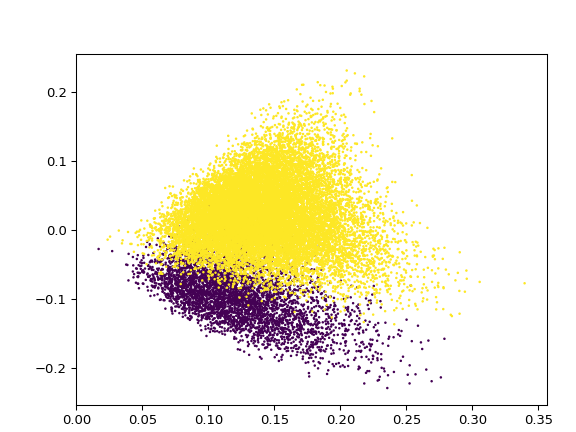

In [62]:
svd_knn = TruncatedSVD(n_components=2,random_state=41)
svd_knn.fit(tfidf_reviews_dev_knn)


tfidf_svd_knn_NORM = normalize(svd_knn.transform(tfidf_reviews_dev_knn))
tfidf_svd_knn = svd_knn.transform(tfidf_reviews_dev_knn)
labels_num_knn = labels_knn.apply(lambda x : 1 if x == 'pos' else 0)
fig_us,ax_knn=plt.subplots()
ax_knn.scatter(tfidf_svd_knn_NORM[:,0],tfidf_svd_knn_NORM[:,1],c=labels_num_knn,s=0.5)
fig_us,ax=plt.subplots()
ax.scatter(tfidf_svd_knn[:,0],tfidf_svd_knn[:,1],c=labels_num_knn,s=0.8)

<IPython.core.display.Javascript object>


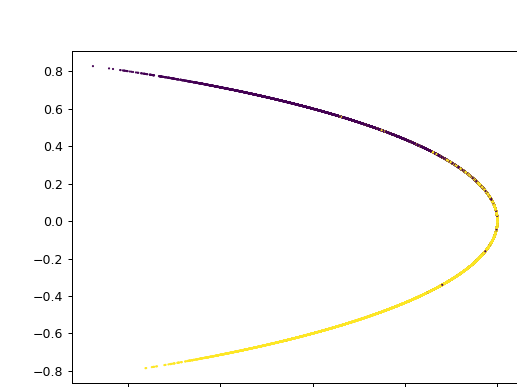

<IPython.core.display.Javascript object>


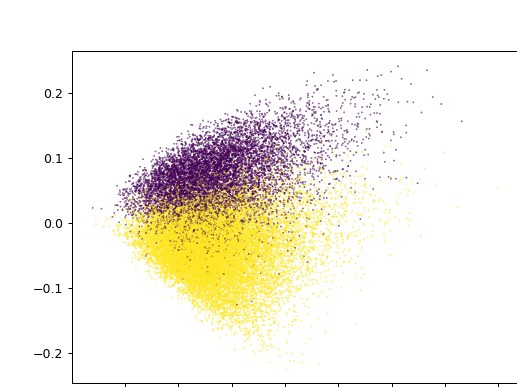

In [44]:
svd_us = TruncatedSVD(n_components=2,random_state=41)
svd_us.fit(tfidf_reviews_dev_us)


tfidf_svd_us_NORM = normalize(svd_us.transform(tfidf_reviews_dev_us))
tfidf_svd_us = svd_us.transform(tfidf_reviews_dev_us)
labels_num_us = labels_us.apply(lambda x : 1 if x == 'pos' else 0)
fig_us,ax_us=plt.subplots()
ax_us.scatter(tfidf_svd_us_NORM[:,0],tfidf_svd_us_NORM[:,1],c=labels_num_us,s=0.5)
fig_us,ax=plt.subplots()
ax.scatter(tfidf_svd_us[:,0],tfidf_svd_us[:,1],c=labels_num_us,s=0.1)

<IPython.core.display.Javascript object>


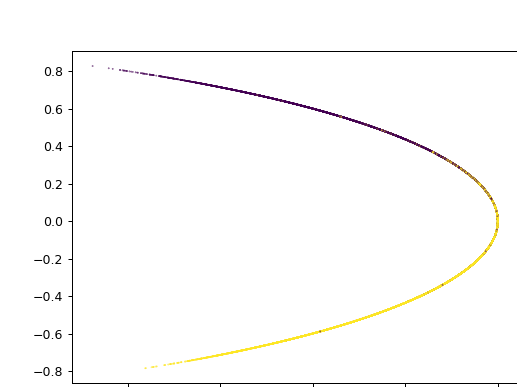

<IPython.core.display.Javascript object>


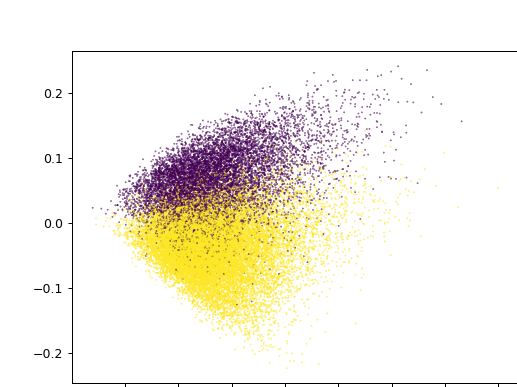

In [46]:
svd = TruncatedSVD(n_components=2,random_state=41)
svd.fit(tfidf_reviews_dev_us)


tfidf_svd_NORM = normalize(svd.transform(tfidf_reviews_dev))
tfidf_svd = svd.transform(tfidf_reviews_dev)
labels_num = reviews_dev_df['class'].apply(lambda x : 1 if x == 'pos' else 0)
fig_us,ax_norm=plt.subplots()

ax_norm.scatter(tfidf_svd_NORM[:,0],tfidf_svd_NORM[:,1],c=labels_num,s=0.1)
fig_us,ax=plt.subplots()
ax.scatter(tfidf_svd[:,0],tfidf_svd[:,1],c=labels_num,s=0.1)

# Singular value decomposition - Visualization

In [ ]:
svd_us = TruncatedSVD(n_components=2,random_state=41)
svd_us.fit(tfidf_reviews_dev_us)


tfidf_svd_us = normalize(svd_us.transform(tfidf_reviews_dev_us))
mask=((tfidf_svd_us[:,0]>=0.80166)&(tfidf_svd_us[:,0]<=0.80167)&(tfidf_svd_us[:,1]>=0.59776)&(tfidf_svd_us[:,1]<=0.59777))
mask_2=((tfidf_svd_us[:,1]>=0.55)&(tfidf_svd_us[:,1]<=0.602488))
merda = []
mask_3=((tfidf_svd_us[:,1]>=-0.5)&(tfidf_svd_us[:,1]<=-0.48))
for ind,val in enumerate(mask_2):
    if val == True and reviews_dev_df.loc[ind,'class'] == 'neg':
        merda.append(reviews_dev_df.loc[ind,'text'])
labels_num_us = labels_us.apply(lambda x : 1 if x == 'pos' else 0)

merda_pos=[]
for ind,val in enumerate(mask_3):
    if val == True and reviews_dev_df.loc[ind,'class'] == 'pos':
        merda_pos.append(reviews_dev_df.loc[ind,'text'])
labels_num_us = labels_us.apply(lambda x : 1 if x == 'pos' else 0)
# Data for a three-dimensional line
fig_us,ax_us=plt.subplots()
ax_us.scatter(tfidf_svd_us[:,0],tfidf_svd_us[:,1],c=labels_num_us,s=0.1)

In [ ]:
len(merda)
for m in merda:
    print(m,'\n\n\n')

In [ ]:
svd_us.get_fe

In [ ]:
len(merda_pos)
for m_p in merda_pos:
    print(m_p,'\n\n\n')

In [32]:
tfidf_reviews_dev_us=normalize(tfidf_reviews_dev)
labels_us = reviews_dev_df['class']

# TUNING - Linear SVC ( computed on TF-IDF )

In [40]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
def gridSearchCV_SVC_US(Reviews_train,reviews_labels):
    classifier = LinearSVC(fit_intercept=True,loss='squared_hinge',tol=1e-6,class_weight='balanced')
    param_grid = { 
                  'C' :[1.0,2.0,3.0]
                   }
    
    gridsearch = GridSearchCV(classifier, param_grid, scoring='f1_weighted', cv=10)
    gridsearch.fit(Reviews_train,reviews_labels)
    return gridsearch
    
Reviews_train,Reviews_test,reviews_labels,test_labels= train_test_split(tfidf_reviews_dev_us,labels_us,train_size=0.85,stratify=labels_us,shuffle=True)
gridsearchCV_SVC_US_=gridSearchCV_SVC_US(Reviews_train,reviews_labels)

y_pred=gridsearchCV_SVC_US_.best_estimator_.predict(Reviews_test)
print(gridsearchCV_SVC_US_.best_estimator_)
print(gridsearchCV_SVC_US_.best_score_)
print(classification_report(y_pred,test_labels))

LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=1e-06,
          verbose=0)
0.9689519047825292
              precision    recall  f1-score   support

         neg       0.96      0.95      0.96      1332
         pos       0.98      0.98      0.98      2841

    accuracy                           0.97      4173
   macro avg       0.97      0.97      0.97      4173
weighted avg       0.97      0.97      0.97      4173



# VALIDATION - Linear SVC ( computed on TF-IDF )

In [42]:
best_estimator = gridsearchCV_SVC_US_.best_estimator_
y_pred=best_estimator.predict(tfidf_reviews_eval)
print(np.unique(y_pred,return_counts=True))

with open(folder + 'res_tfidf_SVC_US_8.csv', 'w') as file:
    file.write('Id,Predicted\n')
    for i,l in enumerate(y_pred):
        file.write(str(i) + ',' + l +'\n')
    file.close()

(array(['neg', 'pos'], dtype=object), array([3969, 8354], dtype=int64))


<IPython.core.display.Javascript object>


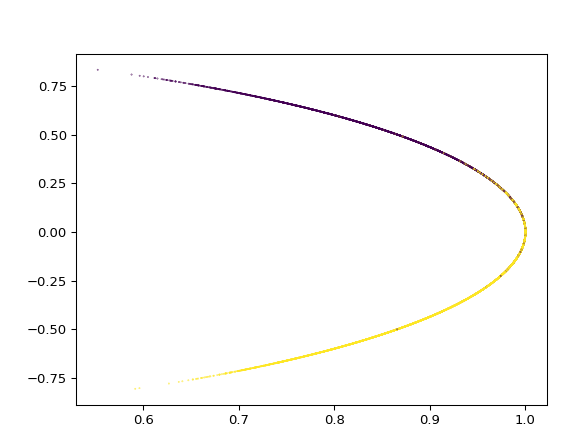

<IPython.core.display.Javascript object>


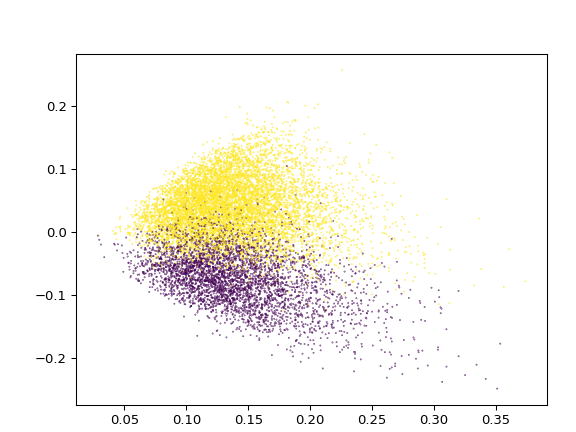

In [14]:
svd_pred = TruncatedSVD(n_components=2,random_state=41)
svd_pred.fit(tfidf_reviews_eval)


tfidf_svd_eval_NORM = normalize(svd_us.transform(tfidf_reviews_eval))
tfidf_svd_eval = svd_pred.transform(tfidf_reviews_eval)
labels_num_eval = pd.Series(y_pred).apply(lambda x : 1 if x == 'pos' else 0)
fig_us,ax_us=plt.subplots()
ax_us.scatter(tfidf_svd_eval_NORM[:,0],tfidf_svd_eval_NORM[:,1],c=labels_num_eval,s=0.1)
fig_us,ax=plt.subplots()
ax.scatter(tfidf_svd_eval[:,0],tfidf_svd_eval[:,1],c=labels_num_eval,s=0.1)

In [29]:
model = best_estimator
feature_to_coef = {
    word: coef for word, coef in zip(
        reviews_vectorizer.get_feature_names(), model.coef_[0]
    )
}



feature_sorted =  sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)

print('Positive features:', end = "\n\n")
for best_positive in feature_sorted[0:10]:
    print (best_positive)
print('')
print('Negative features:', end = "\n\n")
for best_negative in sorted(feature_sorted[-10:]):
    print (best_negative)

Positive features:

('ottim', 4.311511374822364)
('eccellent', 3.3005267985002607)
('perfett', 3.1417828275433557)
('confortevol', 2.711886014494245)
('fantast', 2.6205215610964205)
('unic pecc', 2.5787557096470826)
('consigl', 2.5498832554123334)
('spazios', 2.2013910829673535)
('piac', 2.176525133963317)
('torn', 2.158140153846904)

Negative features:

('non', -3.721485052841784)
('non consigl', -2.5802426596800516)
('non torn', -3.2379032143087216)
('pessim', -3.5158119793840616)
('poc', -2.3675279612199502)
('scars', -2.944523495693793)
('scortes', -2.7540402587025135)
('sporc', -3.0868616677593823)
('terribil', -2.550776459628914)
('vecc', -2.522399643521681)


# Results

In [ ]:
#SVD:
#1.    # min_df:30    max_df:0.7    score:0.966    y_pred: array([3924, 8399] n_components:2895
       # stop_words:['stare','trovare','soggiornare','volere','fare','stare','dire','potere'] +\
                    #['stato','stati','stata','dato','fatto','chiesto','visto','trovato','detto'] +\
                    #['colazione','camera','camere','hotel', 'albergo','stanza','struttura','reception'] +\
                    #['per','su','tra','fra','quando','quindi','così'] 
                
#2.    # min_df:3    max_df:0.7    score:null    y_pred: array([3856, 8467] n_components:30
       # stop_words:['stare','trovare','soggiornare','volere','fare','stare','dire','potere'] +\
                    #['stato','stati','stata','dato','fatto','chiesto','visto','trovato','detto'] +\
                    #['colazione','camera','camere','hotel', 'albergo','stanza','struttura','reception'] +\
                    #['per','su','tra','fra','quando','quindi','così'] 
                
#3...N                #SCHIFOSO PER n_components < 30
                
                
#TF-IDF:
#1.    # min_df:30    max_df:0.7    score:0.964    y_pred: array([3907, 8416] 
       # stop_words:['stare','trovare','soggiornare','volere','fare','stare','dire','potere'] +\
                    #['stato','stati','stata','dato','fatto','chiesto','visto','trovato','detto'] +\
                    #['colazione','camera','camere','hotel', 'albergo','stanza','struttura','reception'] +\
                    #['per','su','tra','fra','quando','quindi','così']

#2.    # min_df:3    max_df:0.7    score:0.968    y_pred: array([3891, 8432]
       # stop_words:['stare','trovare','soggiornare','volere','fare','stare','dire','potere'] +\
                    #['stato','stati','stata','dato','fatto','chiesto','visto','trovato','detto'] +\
                    #['colazione','camera','camere','hotel', 'albergo','stanza','struttura','reception'] +\
                    #['per','su','tra','fra','quando','quindi','così'] 

#3.    # min_df:2    max_df:0.7    score:0.971    y_pred: array([3874, 8449]
       # stop_words:['stare','trovare','soggiornare','volere','fare','stare','dire','potere'] +\
                    #['stato','stati','stata','dato','fatto','chiesto','visto','trovato','detto'] +\
                    #['colazione','camera','camere','hotel', 'albergo','stanza','struttura','reception'] +\
                    #['per','su','tra','fra','quando','quindi','così'] 
                
#4.    # min_df:2    max_df:0.4    score:0.970    y_pred: array([3885, 8438]

       # stop_words:['stare','trovare','soggiornare','volere','fare','stare','dire','potere'] +\
                    #['stato','stati','stata','dato','fatto','chiesto','visto','trovato','detto'] +\
                    #['colazione','camera','camere','hotel', 'albergo','stanza','struttura','reception'] +\
                    #['per','su','tra','fra','quando','quindi','così'] 
                
#5.    # min_df:2    max_df:0.9    score:0.970    y_pred: array([3876, 8447]

       # stop_words:['stare','trovare','soggiornare','volere','fare','stare','dire','potere'] +\
                    #['stato','stati','stata','dato','fatto','chiesto','visto','trovato','detto'] +\
                    #['colazione','camera','camere','hotel', 'albergo','stanza','struttura','reception'] +\
                    #['per','su','tra','fra','quando','quindi','così']
                
#6.    # min_df:2    max_df:1.0    score:0.969    y_pred: array([3873, 8450]

       # stop_words:['stare','trovare','soggiornare','volere','fare','stare','dire','potere'] +\
                    #['stato','stati','stata','dato','fatto','chiesto','visto','trovato','detto'] +\
                    #['colazione','camera','camere','hotel', 'albergo','stanza','struttura','reception'] +\
                    #['per','su','tra','fra','quando','quindi','così']

#7.    # min_df:2    max_df:1.0    score:0.972    y_pred: array([3911, 8412]

       # stop_words:['stare','trovare','soggiornare','volere','fare','stare','dire','potere'] +\
                    #['stato','stati','stata','dato','fatto','chiesto','visto','trovato','detto'] +\
                    #['colazione','camera','camere','hotel', 'albergo','stanza','struttura','reception'] +\
                    #['per','su','tra','fra','quando','quindi','così']ù
#8.    # min_df:2    max_df:1.0  norm="None"   score:0.974    y_pred: array([3903, 8420]

       # stop_words:['stare','trovare','soggiornare','volere','fare','stare','dire','potere'] +\
                    #['stato','stati','stata','dato','fatto','chiesto','visto','trovato','detto'] +\
                    #['colazione','camera','camere','hotel', 'albergo','stanza','struttura','reception'] +\
                    #['per','su','tra','fra','quando','quindi','così']
                
                 